In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import pyarrow.parquet as pq
import pickle
import numpy as np
import time
import seaborn as sns
from itertools import combinations
import multiprocessing as mp
from tqdm import tqdm
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [3]:
table2 = pq.read_table('E:\\Downloads\\stats-econ-homework\\obs_data.parquet')
base=table2.to_pandas()

In [4]:
base.head()

id       date collections_start  \
0  94b47b2c-24ca-4c0b-8a1b-d47b8c6094ce 2017-01-01        2017-01-01   
1  ee254bce-3eec-46cd-a440-826631a44783 2017-01-01        2017-01-01   
2  74a49cd6-44f8-41cc-926b-b324794f6837 2017-01-01        2017-01-01   
3  e4552188-6002-44f4-b539-1043cf1dd057 2017-01-01        2017-01-01   
4  d3005d9c-2d58-4986-9007-67a6758dd7ef 2017-01-01        2017-01-01   

   days_late  bureau_1  bureau_2  late_payments collection__end  \
0          0         0         0              0      2017-02-13   
1          0         0         0             40      2017-06-14   
2          0         0         0              0      2017-02-03   
3          0         0         0              0      2017-03-01   
4          0         0         0              0      2017-02-15   

   std_revolving_balance_30  agreement_amount_mean  \
0                       0.0                    NaN   
1                       0.0                    NaN   
2                       3.0                    NaN   
3                       9.0                    NaN   
4                       1.0                    NaN   

   oustanting_balance_weight_30  oustanting_balance_weight_90  \
0                          69.0                          16.0   
1                          55.0                           1.0   
2                        1635.0                          15.0   
3                           2.0                           9.0   
4                          24.0                           3.0   

   max_installments_balance_90  max_payment_90  \
0                          0.0           540.0   
1                          0.0            18.0   
2                          0.0            58.0   
3                          0.0             0.0   
4                          0.0         33240.0   

   sum_limit_request_time_weight_180  loss_balance  avg_late_balance_0_180  \
0                                2.0          19.0                    23.0   
1                                1.0          33.0                     1.0   
2                                0.0         111.0                    93.0   
3                                1.0           0.0                   233.0   
4                                2.0          42.0                     1.0   

   email_event_30  count_inbound_call_inbound_30  avg_call_duration_30  \
0             1.0                            1.0                   0.0   
1             1.0                            0.0                   0.0   
2             0.0                            0.0                   2.0   
3             1.0                            1.0                   8.0   
4             1.0                            1.0                   2.0   

   avg_installments_balance_30  charges_agreement_mean  \
0                          0.0                     NaN   
1                          0.0                     NaN   
2                          1.0                     NaN   
3                          3.0                     NaN   
4                          0.0                     NaN   

   ongoing_agreement_amount  asset_late_balance  \
0                       NaN                20.0   
1                       NaN                 0.0   
2                       NaN                71.0   
3                       NaN                54.0   
4                       NaN                 7.0   

   ongoing_agreement_downpayment  recovery_balance  \
0                            NaN               2.0   
1                            NaN               1.0   
2                            NaN               0.0   
3                            NaN               0.0   
4                            NaN               1.0   

   std_installments_balance_0_90  last_email_engagement  last_chat_engagement  \
0                            0.0                    NaN                  16.0   
1                            0.0                  162.0                   NaN   
2                            0.0              

In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53939 entries, 0 to 53938
Data columns (total 44 columns):
id                                               53939 non-null object
date                                             53939 non-null datetime64[ns]
collections_start                                53939 non-null datetime64[ns]
days_late                                        53939 non-null int64
bureau_1                                         53939 non-null int64
bureau_2                                         53939 non-null int64
late_payments                                    53939 non-null int64
collection__end                                  32062 non-null datetime64[ns]
std_revolving_balance_30                         53939 non-null float64
agreement_amount_mean                            8615 non-null float64
oustanting_balance_weight_30                     53939 non-null float64
oustanting_balance_weight_90                     53939 non-null float64
max_installments

In [6]:
base.describe()

days_late      bureau_1      bureau_2  late_payments  \
count  53939.000000  53939.000000  53939.000000   53939.000000   
mean      36.569328      0.008139      0.007879      11.509298   
std       29.209864      0.089848      0.088416      21.098107   
min        0.000000      0.000000      0.000000       0.000000   
25%       14.000000      0.000000      0.000000       0.000000   
50%       30.000000      0.000000      0.000000       0.000000   
75%       53.000000      0.000000      0.000000      10.000000   
max      165.000000      1.000000      1.000000     620.000000   

       std_revolving_balance_30  agreement_amount_mean  \
count              53939.000000            8615.000000   
mean                   7.313094            1850.127104   
std                   16.114278            1336.698371   
min                   -1.000000             261.000000   
25%                    3.000000             993.000000   
50%                    4.000000            1451.000000   
75%                    7.000000            2294.000000   
max                  566.000000            9471.000000   

       oustanting_balance_weight_30  oustanting_balance_weight_90  \
count                  53939.000000                   53939.00000   
mean                     278.680343                      10.69117   
std                     1177.434203                      16.77419   
min                      -39.000000                       0.00000   
25%                       40.000000                       2.00000   
50%                       91.000000                       5.00000   
75%                      206.000000                      11.00000   
max                    38632.000000                     183.00000   

       max_installments_balance_90  max_payment_90  \
count                 53939.000000    53939.000000   
mean                     11.636274     4160.861343   
std                      44.168598     6566.433172   
min                       0.000000     -755.000000   
25%                       1.000000      877.000000   
50%                       2.000000     2195.000000   
75%                       6.000000     4810.000000   
max                    1029.000000    93248.000000   

       sum_limit_request_time_weight_180  loss_balance  \
count                       53939.000000  53939.000000   
mean                            1.015740    531.582695   
std                             0.250759   3882.446475   
min                             0.000000     -6.000000   
25%                             1.000000     23.000000   
50%                             1.000000     32.000000   
75%                             1.000000     99.000000   
max                             4.000000  80193.000000   

       avg_late_balance_0_180  email_event_30  count_inbound_call_inbound_30  \
count            53939.000000    53939.000000                   53939.000000   
mean               364.790245        0.567104                       0.889412   
std                801.419988        0.495481                       0.313624   
min                  0.000000        0.000000                       0.000000   
25%                111.000000        0.000000                       1.000000   
50%                129.000000        1.000000                       1.000000   
75%                334.000000        1.000000                       1.000000   
max              19486.000000        1.000000                       1.000000   

       avg_call_duration_30  avg_installments_balance_30  \
count          53939.000000                 53939.000000   
mean               2.242607                     3.048851   
std                2.525473                     6.640371   
min                0.000000                     0.000000   
25%                1.000000                     1.000000   
50%                2.000000                     1.000000   
75%                3.000000                     3.000000   
max               61.000000                   117.000000   

In [7]:
base[base['bureau_1']==1].head()

id       date collections_start  \
804  ee254bce-3eec-46cd-a440-826631a44783 2017-01-16        2017-01-01   
845  e4552188-6002-44f4-b539-1043cf1dd057 2017-01-16        2017-01-01   
873  f84bc28e-7298-4d59-a315-5a3c1125f820 2017-01-16        2017-01-01   
880  40249e57-7de1-42fb-9201-afab1a3965a4 2017-01-16        2017-01-01   
898  abd31cd5-ccc6-415c-9c76-124a01f6c898 2017-01-17        2017-01-02   

     days_late  bureau_1  bureau_2  late_payments collection__end  \
804         15         1         0              0      2017-06-14   
845         15         1         0             50      2017-03-01   
873         15         1         0             30             NaT   
880         15         1         0             20      2017-02-18   
898         15         1         0              0      2017-03-31   

     std_revolving_balance_30  agreement_amount_mean  \
804                       0.0                    NaN   
845                       9.0                    NaN   
873                       0.0                 1587.0   
880                       2.0                    NaN   
898                       0.0                    NaN   

     oustanting_balance_weight_30  oustanting_balance_weight_90  \
804                         127.0                           2.0   
845                          40.0                          13.0   
873                          32.0                          12.0   
880                          17.0                          51.0   
898                          50.0                          10.0   

     max_installments_balance_90  max_payment_90  \
804                          0.0            18.0   
845                          0.0             0.0   
873                          4.0         29579.0   
880                          0.0             0.0   
898                          0.0           879.0   

     sum_limit_request_time_weight_180  loss_balance  avg_late_balance_0_180  \
804                                1.0          33.0                    28.0   
845                                1.0           0.0                   158.0   
873                                1.0           0.0                   178.0   
880                                2.0           0.0                  2824.0   
898                                1.0           4.0                   441.0   

     email_event_30  count_inbound_call_inbound_30  avg_call_duration_30  \
804             1.0                            0.0                   0.0   
845             1.0                            1.0                   8.0   
873             0.0                            1.0                   2.0   
880             0.0                            1.0                  14.0   
898             1.0                            1.0                   2.0   

     avg_installments_balance_30  charges_agreement_mean  \
804                          0.0                     NaN   
845                          3.0                     NaN   
873                          0.0                     5.0   
880                          1.0                     NaN   
898                          0.0                     NaN   

     ongoing_agreement_amount  asset_late_balance  \
804                       NaN                 0.0   
845                       NaN                54.0   
873                       NaN               102.0   
880                       NaN             16662.0   
898                       NaN               110.0   

     ongoing_agreement_downpayment  recovery_balance  \
804                            NaN               1.0   
845                            NaN               0.0   
873                            NaN               2.0   
880                            NaN               0.0   
898                            NaN               2.0   

     std_installments_balance_0_90  last_email_engagement  \
804                            0.0                    NaN   
845                            0.0               

In [8]:
base[base['bureau_2']==1].head()

id       date collections_start  \
1053  e4552188-6002-44f4-b539-1043cf1dd057 2017-01-18        2017-01-01   
1068  d3005d9c-2d58-4986-9007-67a6758dd7ef 2017-01-18        2017-01-01   
1090  40249e57-7de1-42fb-9201-afab1a3965a4 2017-01-18        2017-01-01   
1107  abd31cd5-ccc6-415c-9c76-124a01f6c898 2017-01-19        2017-01-02   
1153  d504d6a1-1f80-4836-9c04-75f4acfbeea4 2017-01-19        2017-01-02   

      days_late  bureau_1  bureau_2  late_payments collection__end  \
1053         17         0         1              0      2017-03-01   
1068         17         0         1              0      2017-02-15   
1090         17         0         1              0      2017-02-18   
1107         17         0         1              0      2017-03-31   
1153         17         0         1              0      2017-04-24   

      std_revolving_balance_30  agreement_amount_mean  \
1053                       9.0                    NaN   
1068                       1.0                    NaN   
1090                       2.0                    NaN   
1107                       0.0                 2895.0   
1153                       1.0                    NaN   

      oustanting_balance_weight_30  oustanting_balance_weight_90  \
1053                          40.0                          13.0   
1068                         117.0                           7.0   
1090                          17.0                          51.0   
1107                          50.0                          10.0   
1153                         110.0                           3.0   

      max_installments_balance_90  max_payment_90  \
1053                          0.0             0.0   
1068                          0.0         33240.0   
1090                          0.0             0.0   
1107                          0.0           879.0   
1153                          0.0           162.0   

      sum_limit_request_time_weight_180  loss_balance  avg_late_balance_0_180  \
1053                                1.0           0.0                   158.0   
1068                                2.0          42.0                    43.0   
1090                                2.0           0.0                  2824.0   
1107                                1.0           4.0                   441.0   
1153                                1.0         167.0                    21.0   

      email_event_30  count_inbound_call_inbound_30  avg_call_duration_30  \
1053             1.0                            1.0                   8.0   
1068             1.0                            1.0                   2.0   
1090             0.0                            1.0                  14.0   
1107             1.0                            1.0                   2.0   
1153             1.0                            1.0                   2.0   

      avg_installments_balance_30  charges_agreement_mean  \
1053                          3.0                     NaN   
1068                          0.0                     NaN   
1090                          1.0                     NaN   
1107                          0.0                    21.0   
1153                          0.0                     NaN   

      ongoing_agreement_amount  asset_late_balance  \
1053                       NaN                54.0   
1068                       NaN                 7.0   
1090                       NaN             16662.0   
1107                       NaN               110.0   
1153                       NaN                 5.0   

      ongoing_agreement_downpayment  recovery_balance  \
1053                            NaN               0.0   
1068                            NaN               1.0   
1090                            NaN               0.0   
1107                            NaN               2.0   
1153                            NaN               7.0   

      std_installments_balance_0_90  last_email_engagement  \
1053                            0.0               

In [9]:
base.groupby(['bureau_1','bureau_2']).mean()

days_late  late_payments  std_revolving_balance_30  \
bureau_1 bureau_2                                                       
0        0         36.904437      11.457748                  7.288780   
         1         17.000000      11.835294                  8.680000   
1        0         15.000000      17.425968                  8.929385   

                   agreement_amount_mean  oustanting_balance_weight_30  \
bureau_1 bureau_2                                                        
0        0                   1845.482665                    279.156835   
         1                   1900.312500                    222.395294   
1        0                   2359.605634                    275.562642   

                   oustanting_balance_weight_90  max_installments_balance_90  \
bureau_1 bureau_2                                                              
0        0                            10.645765                    11.580236   
         1                            14.611765                    15.750588   
1        0                            12.384966                    14.428246   

                   max_payment_90  sum_limit_request_time_weight_180  \
bureau_1 bureau_2                                                      
0        0            4148.699651                           1.015506   
         1            5011.247059                           1.030588   
1        0            4807.940774                           1.029613   

                   loss_balance  avg_late_balance_0_180  email_event_30  \
bureau_1 bureau_2                                                         
0        0           534.937070              362.971493        0.566802   
         1           257.868235              510.832941        0.588235   
1        0           391.025057              443.291572        0.583144   

                   count_inbound_call_inbound_30  avg_call_duration_30  \
bureau_1 bureau_2                                                        
0        0                              0.890061              2.238210   
         1                              0.856471              2.602353   
1        0                              0.842825              2.425968   

                   avg_installments_balance_30  charges_agreement_mean  \
bureau_1 bureau_2                                                        
0        0                            3.041564                7.195991   
         1                            3.720000                7.000000   
1        0                            3.280182                8.985915   

                   ongoing_agreement_amount  asset_late_balance  \
bureau_1 bureau_2                                                 
0        0                      1779.446014          986.901441   
         1                      2528.727273         1488.063529   
1        0                      1907.652174         1459.861048   

                   ongoing_agreement_downpayment  recovery_balance  \
bureau_1 bureau_2                                                    
0        0                            294.529710          1.525294   
         1                            418.409091          1.407059   
1        0                            279.869565          1.371298   

                   std_installments_balance_0_90  last_email_engagement  \
bureau_1 bureau_2                                                         
0        0                              5.971192             249.563882   
         1                              7.644706             235.883117   
1        0                              7.104784             228.275304   

                   last_chat_engagement  finantial_institutions  \
bureau_1 bureau_2                                                 
0        0                   146.847967                2.347376   
         1                   112.973094                2.536471   
1        0                   129.660793                2.391800   

   

In [10]:
bureau_1=base[base['bureau_1']==1]['id'].unique()
bureau_2=base[base['bureau_2']==1]['id'].unique()


In [11]:
control=list((set(base['id'])-set(bureau_1))-set(bureau_2))
both=set(bureau_1) & set(bureau_2)
treatment1=set(bureau_1) - set(bureau_2)
treatment2=set(bureau_2) - set(bureau_1)

In [12]:
base.loc[base['id'].isin(control),'type_obs']='control'

base.loc[base['id'].isin(both),'type_obs']='both'
base.loc[base['id'].isin(treatment1),'type_obs']='bureau_1'
base.loc[base['id'].isin(treatment2),'type_obs']='bureau_2'


In [13]:
base['collection_time']=base['collection__end']-base['collections_start']
base['collection_time']=base['collection_time'].dt.days
base['month']=base['collections_start'] .dt.month

In [475]:
groupavgs=base[base['month']==1].groupby(['days_late','type_obs']).mean().unstack()
groupmean=base[base['month']==1].groupby(['days_late','type_obs']).median().unstack()
groupstd=base[base['month']==1].groupby(['days_late','type_obs']).std().unstack()

In [15]:
max_date_obs=base[base['days_late']>=15].groupby('id')['date'].idxmax().reset_index()
min_date_obs=base[base['id'].isin(max_date_obs['id'])].groupby('id')['date'].idxmin().reset_index()

In [1017]:
base[base['id'].isin(min_date_obs['id'])][['id','type_obs']].drop_duplicates().groupby(['type_obs']).count()

id
type_obs     
both      215
bureau_1  224
bureau_2  210
control   253

In [16]:
start_mean=base.loc[min_date_obs['date']].fillna(0).groupby('type_obs').mean().T
end_mean=base.loc[ max_date_obs['date']].fillna(0).groupby('type_obs').mean().T

In [17]:
end_mean-start_mean

type_obs                                              both    bureau_1  \
days_late                                        56.674419   58.227679   
bureau_1                                          0.000000    0.013393   
bureau_2                                          0.009302    0.000000   
late_payments                                     4.837209    0.357143   
std_revolving_balance_30                         -4.413953   -1.013393   
agreement_amount_mean                            57.265116   83.232143   
oustanting_balance_weight_30                      0.106977   18.071429   
oustanting_balance_weight_90                      0.302326    0.147321   
max_installments_balance_90                      -0.539535   -0.575893   
max_payment_90                                -1066.260465 -613.075893   
sum_limit_request_time_weight_180                -0.027907    0.022321   
loss_balance                                    -18.753488   59.741071   
avg_late_balance_0_180                          -21.265116  -40.125000   
email_event_30                                    0.013953   -0.008929   
count_inbound_call_inbound_30                     0.120930    0.120536   
avg_call_duration_30                             -0.130233    0.075893   
avg_installments_balance_30                      -0.083721    0.169643   
charges_agreement_mean                            0.060465    0.406250   
ongoing_agreement_amount                         21.186047  -16.120536   
asset_late_balance                              -26.293023  -24.616071   
ongoing_agreement_downpayment                     0.479070   -2.330357   
recovery_balance                                  0.018605   -0.071429   
std_installments_balance_0_90                    -0.097674   -0.160714   
last_email_engagement                            30.227907   -1.120536   
last_chat_engagement                             -5.483721   -9.111607   
finantial_institutions                            0.004651    0.000000   
downpayment_mean                                 18.186047   16.946429   
avg_spends                                        1.320930    0.026786   
score_1                                           0.344186   -0.241071   
score_2                                          -0.032558   -0.508929   
score_3                                           0.032558   -1.419643   
income_score_1                                   27.669767    1.183036   
count_previous_delinquencies                      0.000000    0.000000   
income_score_2                                    0.000000    0.000000   
age                                               0.000000    0.000000   
mean_previous_delinquencies_amount_weight_180  -156.939535 -134.892857   
mean_previous_delinquencies_duration_90          -0.581395    0.187500   
score_max_credit_limit                            0.000000    0.000000   
credit_limit_utilization                          0.000000    0.000000   
sum_spends_360                                    0.000000    0.000000   
collection_time                                   0.000000    0.000000   
month                                             0.000000    0.000000   

type_obs                                         bureau_2     control  
days_late                                       60.509524   56.399209  
bureau_1                                         0.000000    0.000000  
bureau_2                                         0.014286    0.000000  
late_payments                                    2.380952    0.395257  
std_revolving_balance_30                        -0.171429   -0.719368  
agreement_amount_mean                          122.290476   75.640316  
oustanting_balance_weight_30                   -19.800000  -20.901186  
oustanting_balance_weight_90                     0.023810    0.015810  
max_installments_balance_90                     -1.576190   -0.098814  
max_payment_90                                -521.914286   35.003953  
sum_limit_request_time_we

In [18]:
base['log_late_balance'] =np.log(base['asset_late_balance'])
base['log_max_payment_90'] =np.log(base['max_payment_90'])

C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:

g=base[['type_obs',
        'log_late_balance',
        'days_late',
        'late_payments',
        'agreement_amount_mean',
        'log_max_payment_90',
        'downpayment_mean',
        'avg_spends',
        'age',
       'log_late_balance']].melt(['type_obs','days_late'])

g=g[(g['days_late'].isin([1,15,16,17,30]))]

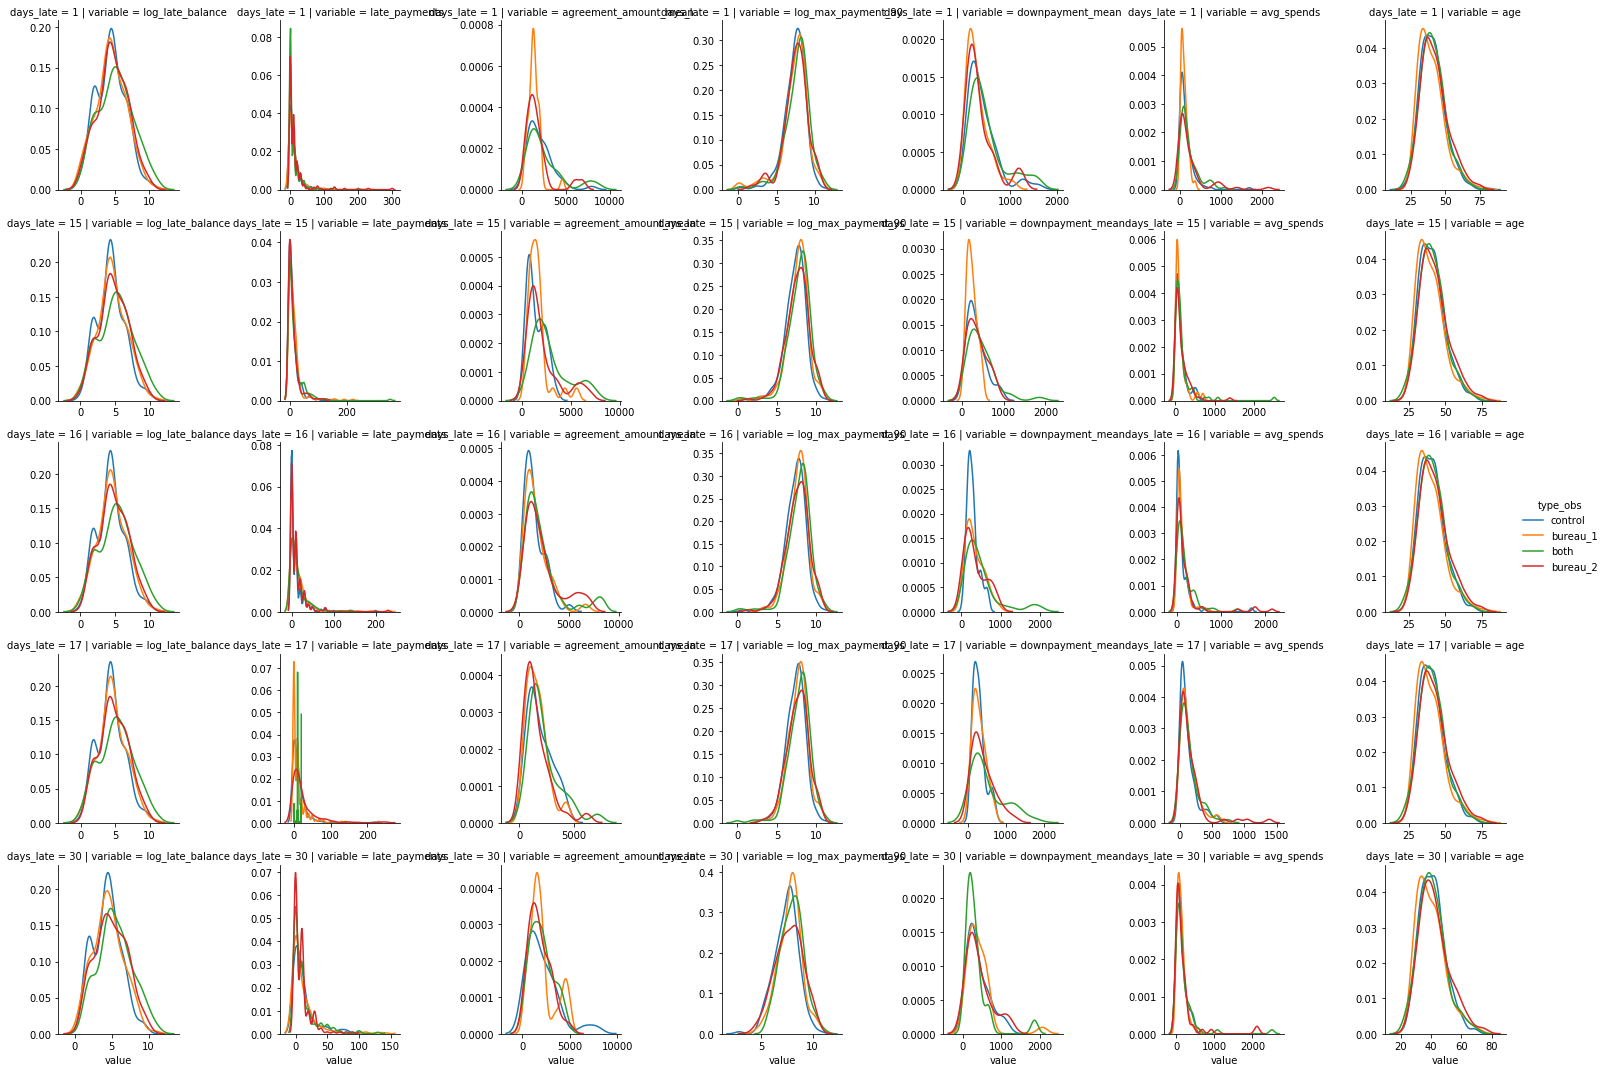

In [20]:

g1 = sns.FacetGrid(g  ,sharex=False,sharey=False,height=3
    
    
    , col='variable', hue="type_obs",row='days_late')
g1= (g1.map(sns.distplot, 'value',hist=False))
g1.add_legend()

C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


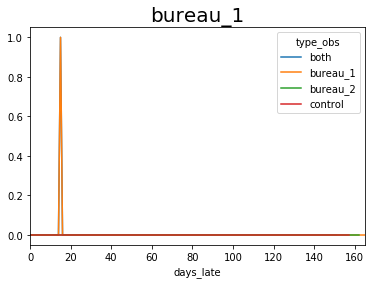

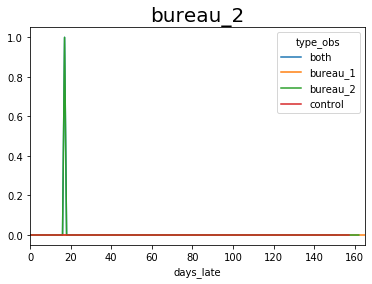

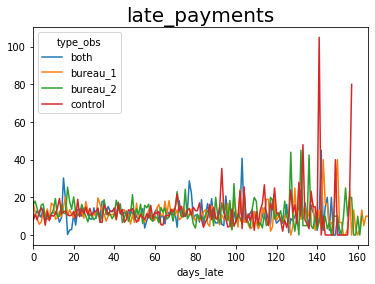

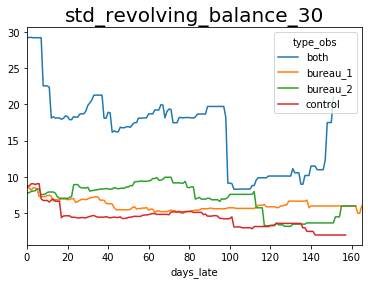

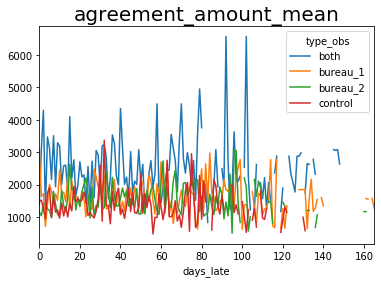

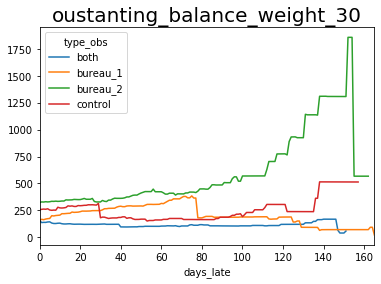

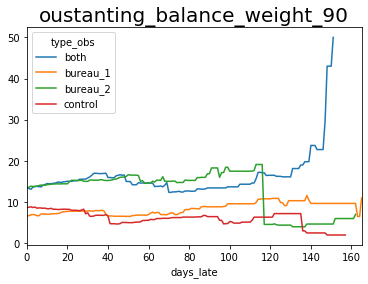

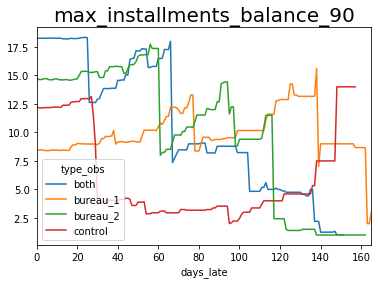

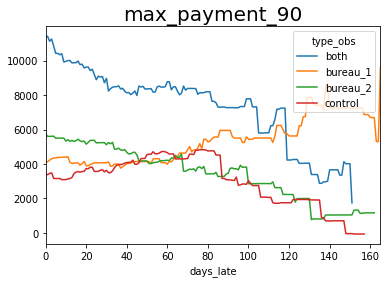

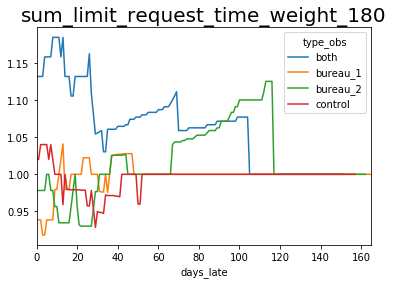

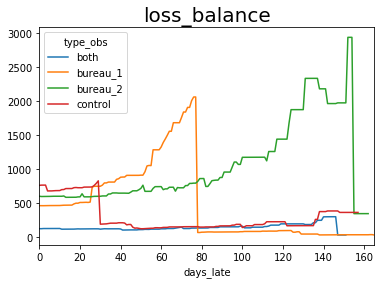

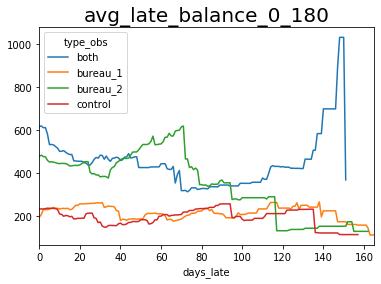

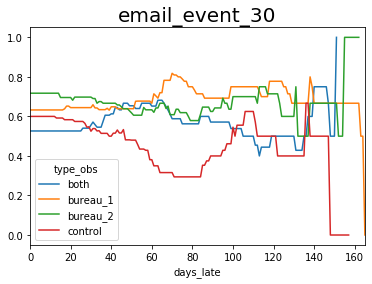

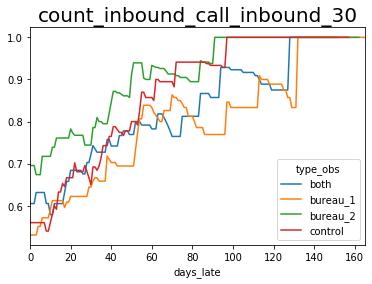

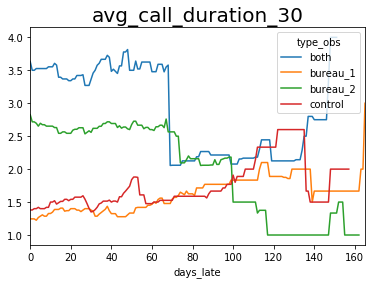

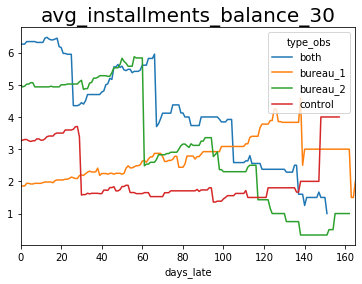

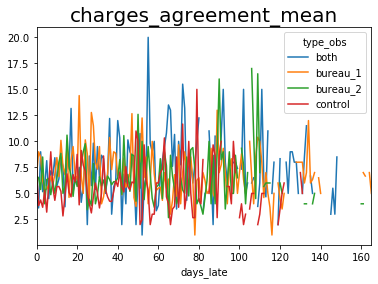

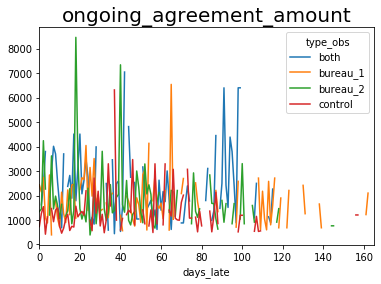

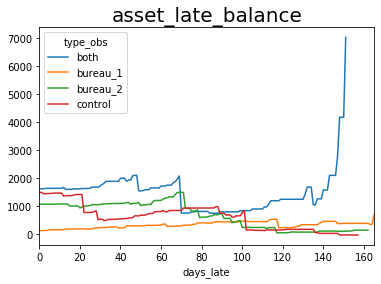

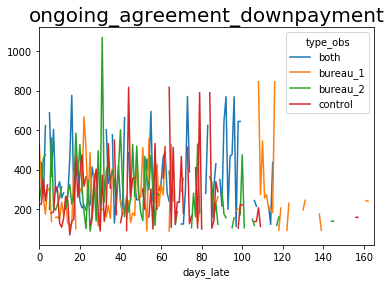

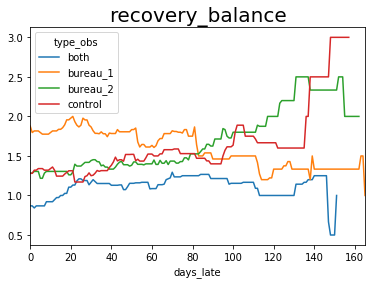

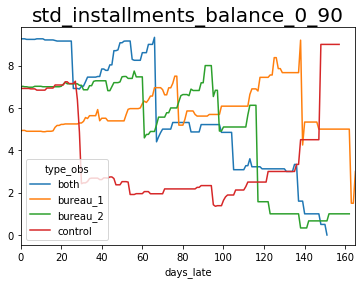

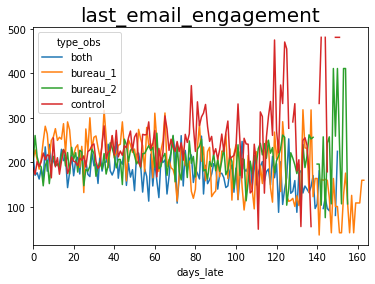

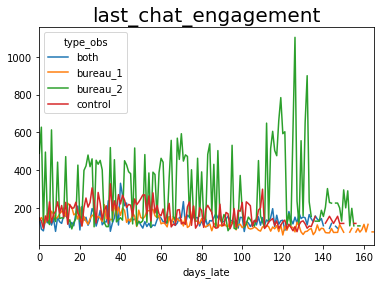

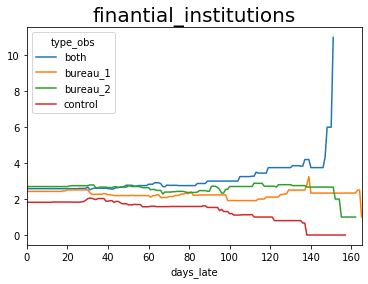

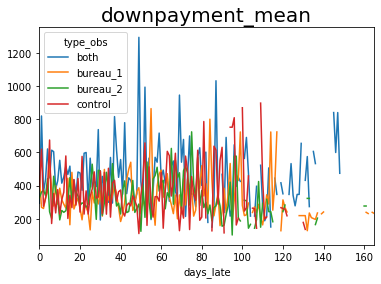

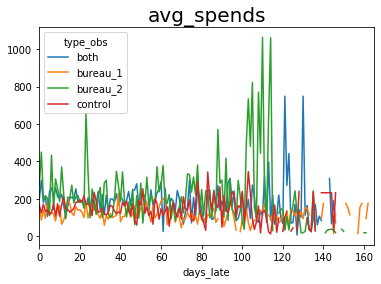

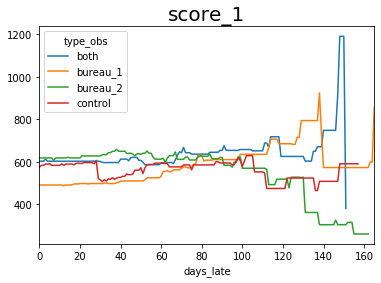

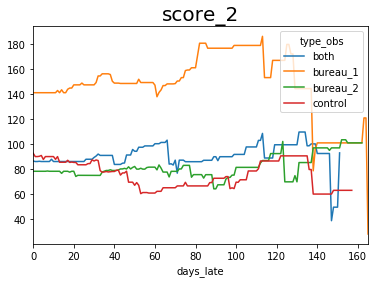

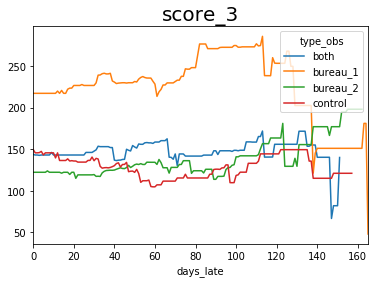

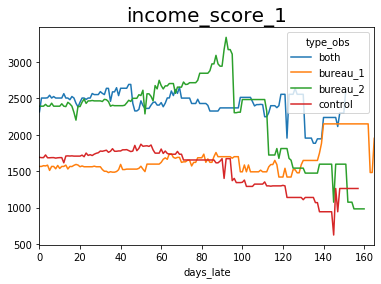

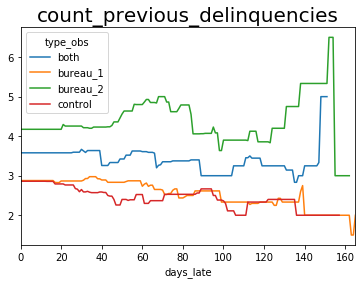

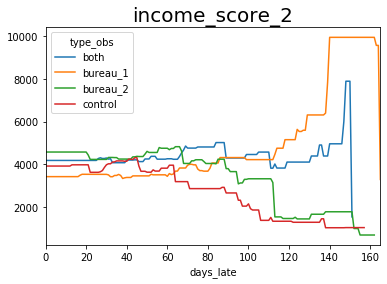

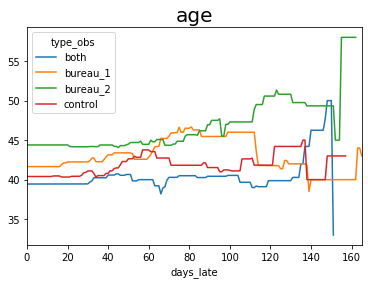

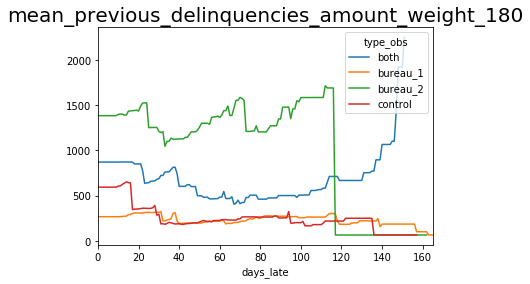

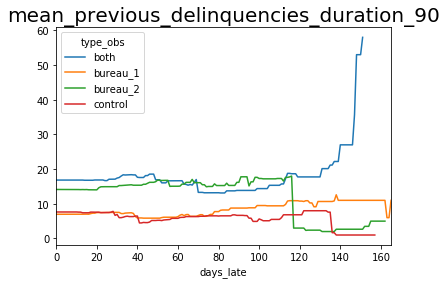

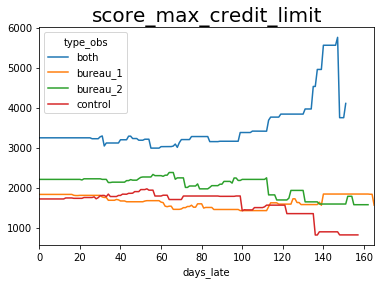

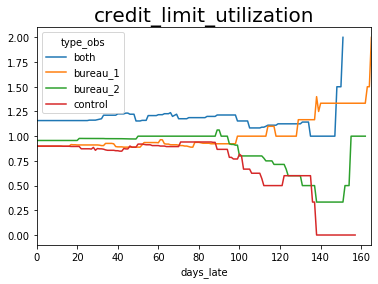

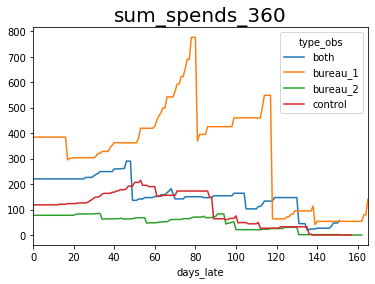

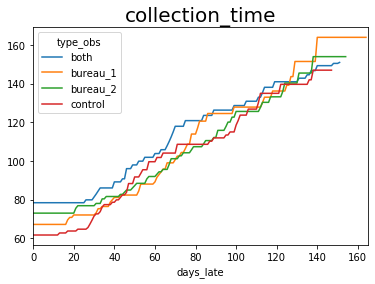

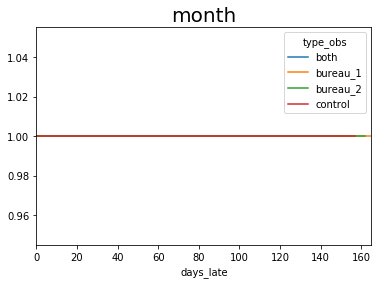

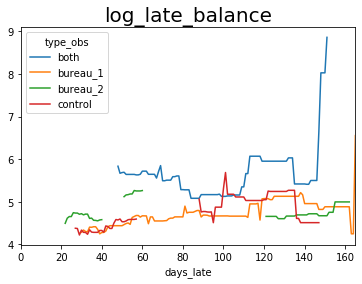

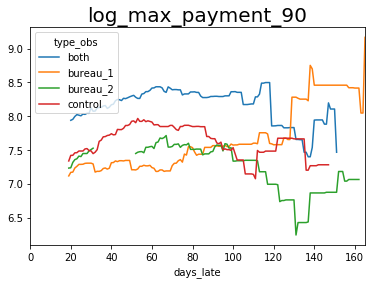

In [476]:
for i in  base.columns:
    try:
        
        avgs=groupavgs[i].plot()
        avgs.set_title(i, fontsize=20)  
        avgs.show()
    except:
        continue

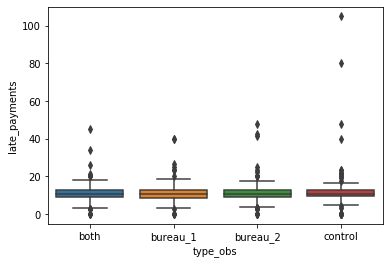

In [327]:
sns.boxplot(data=groupavgs.stack().reset_index(),y='late_payments',x='type_obs')

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

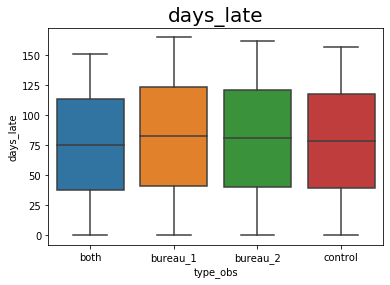

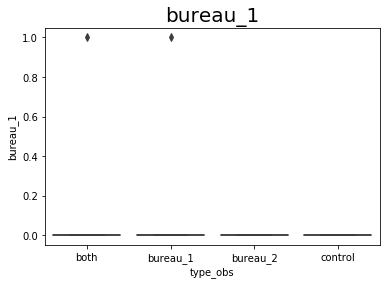

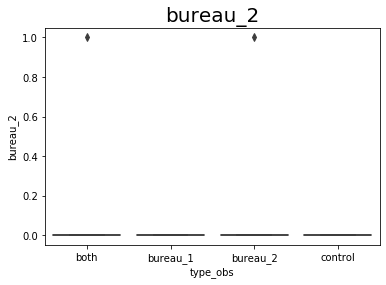

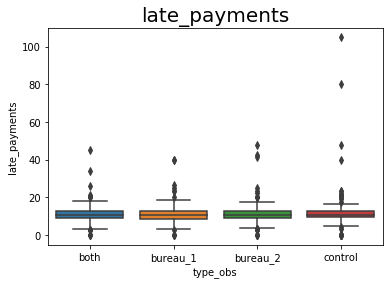

<Figure size 432x288 with 0 Axes>

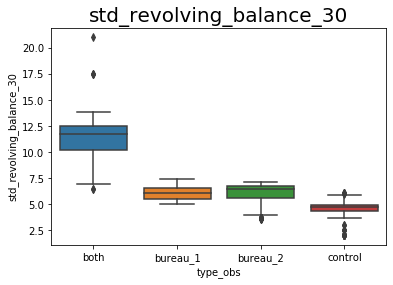

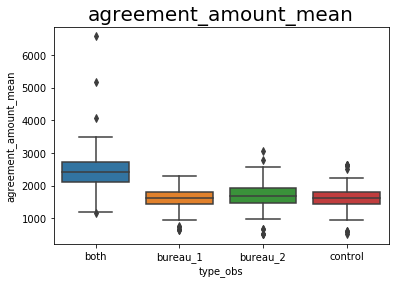

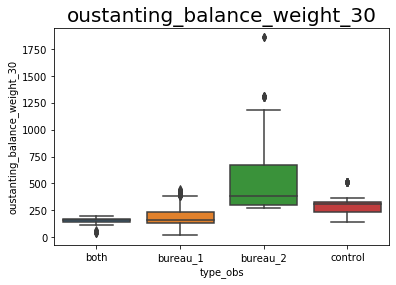

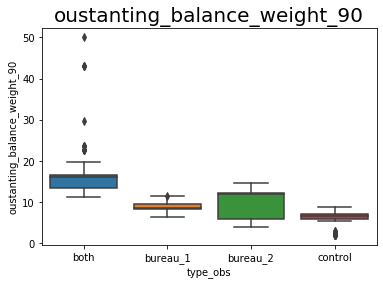

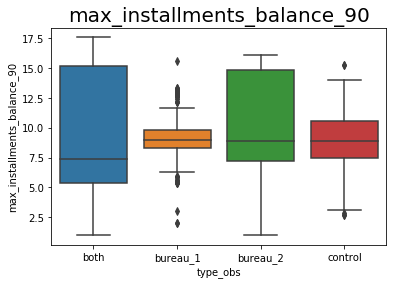

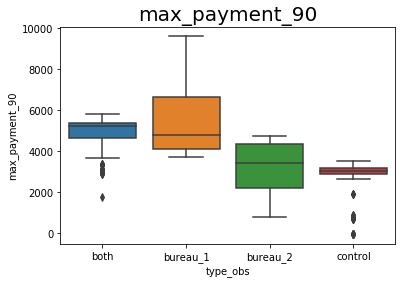

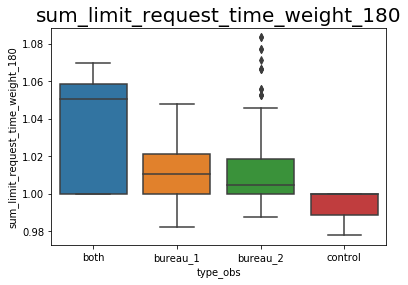

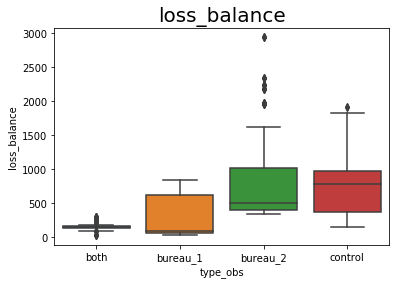

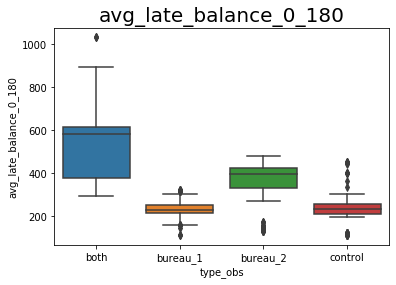

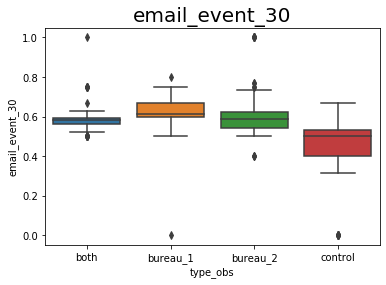

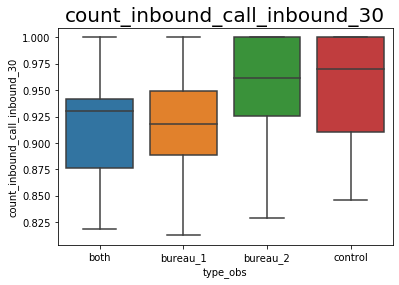

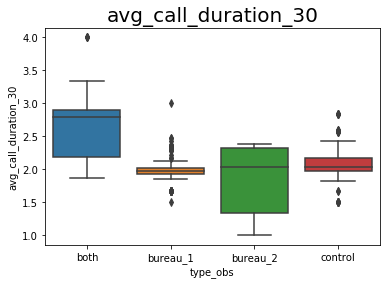

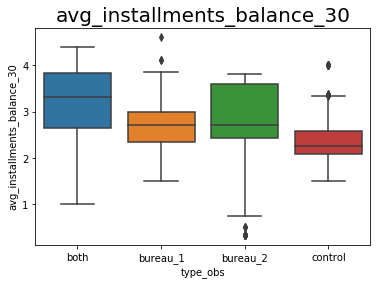

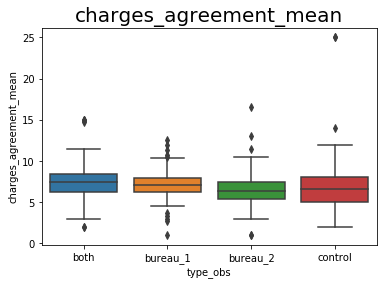

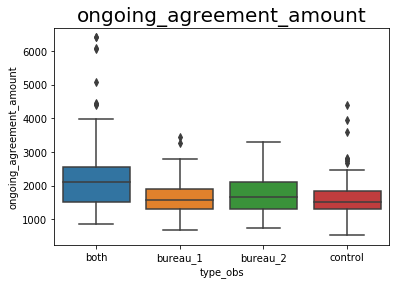

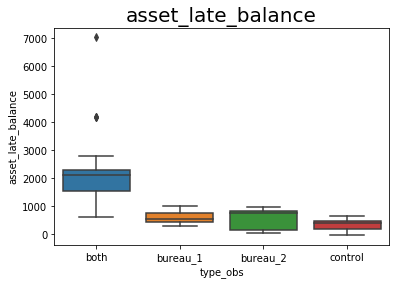

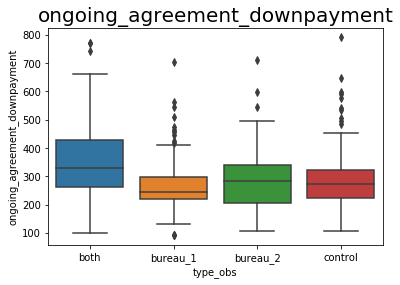

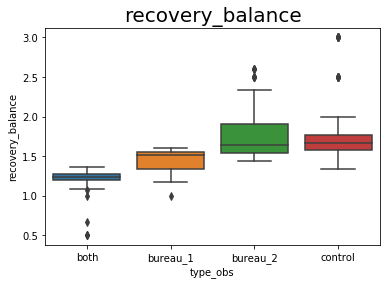

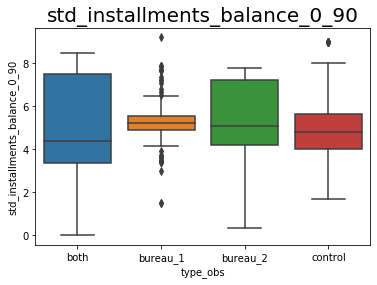

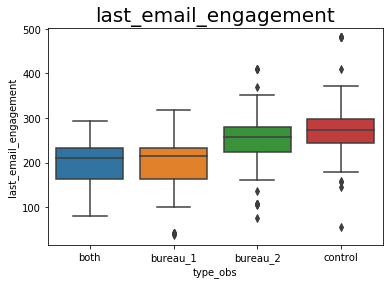

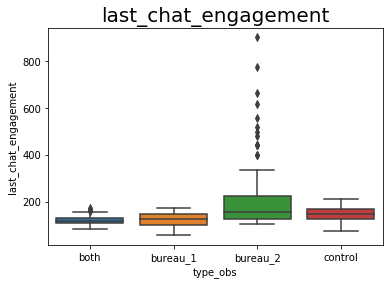

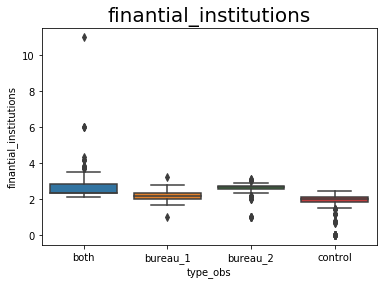

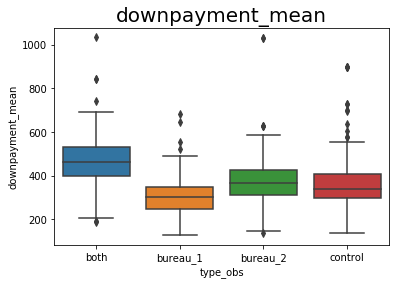

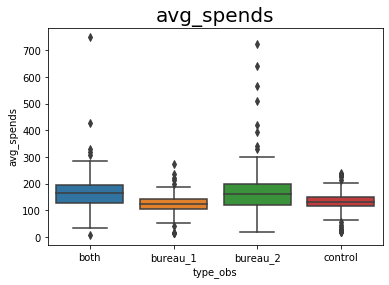

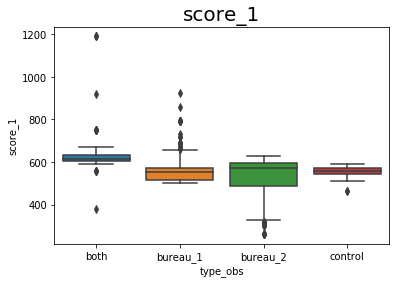

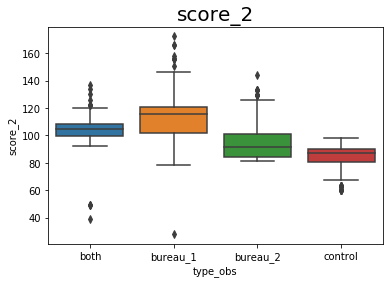

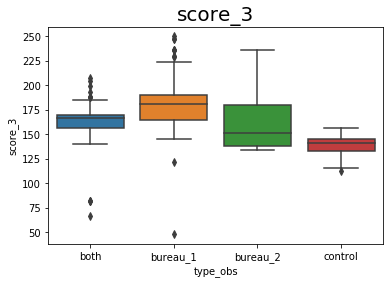

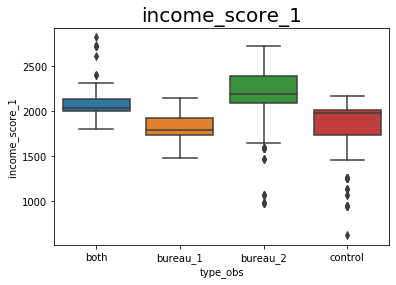

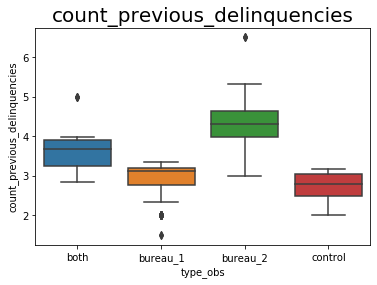

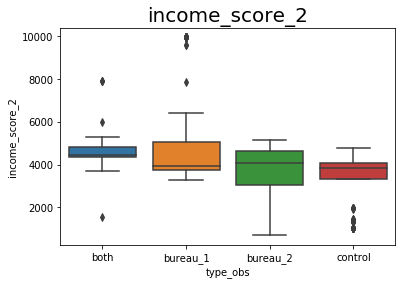

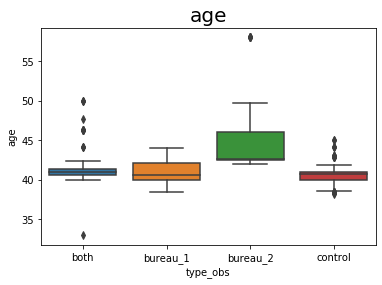

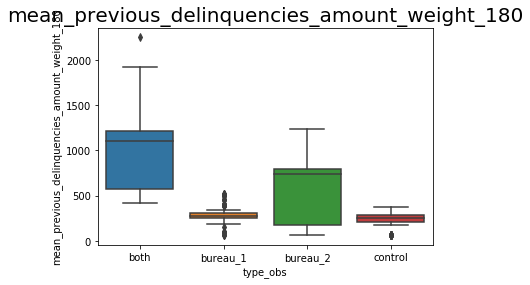

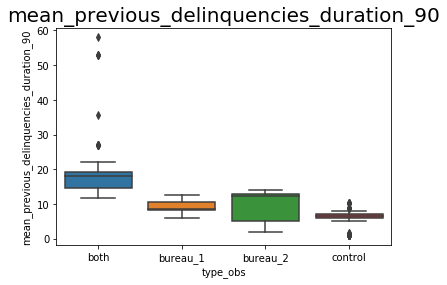

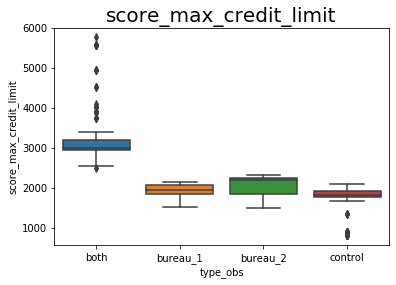

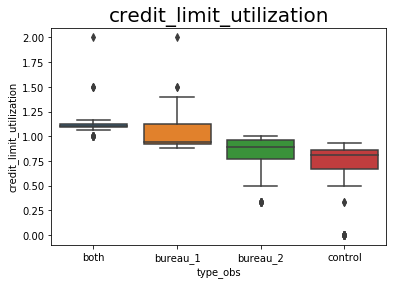

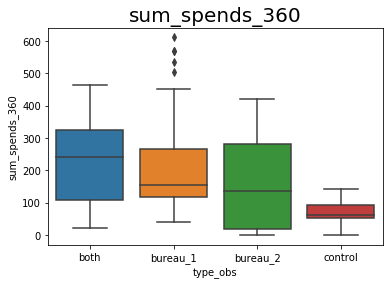

<Figure size 432x288 with 0 Axes>

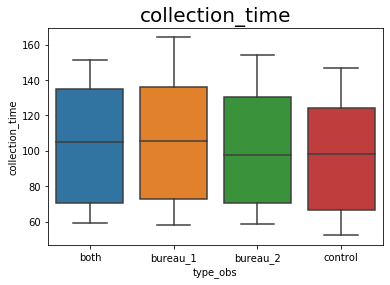

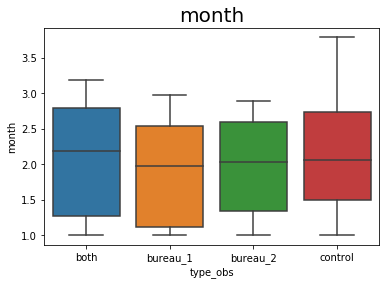

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [330]:
for i in  base.columns:
    try:
        plt.figure()
        avgs=sns.boxplot(data=groupavgs.stack().reset_index(),y=i,x='type_obs')
        
        avgs.set_title(i, fontsize=20)  
        avgs
    except:
        continue

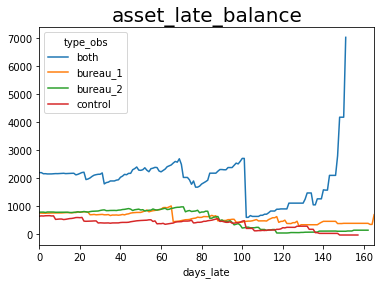

In [22]:
avgs=groupavgs['asset_late_balance'].plot()
avgs.set_title('asset_late_balance', fontsize=20)  
avgs

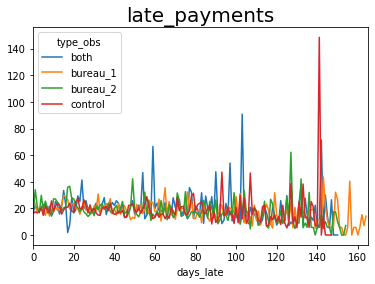

In [23]:
avgs=groupstd['late_payments'].plot()
avgs.set_title('late_payments', fontsize=20)  
avgs

In [24]:
#time=base.loc[ max_date_obs['date']].fillna(0).groupby(['type_obs','collection_time'])['id'].count()

In [1025]:
time=base.iloc[ max_date_obs['date']][base['month']<3]   [['type_obs','days_late','month']].fillna(0)

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


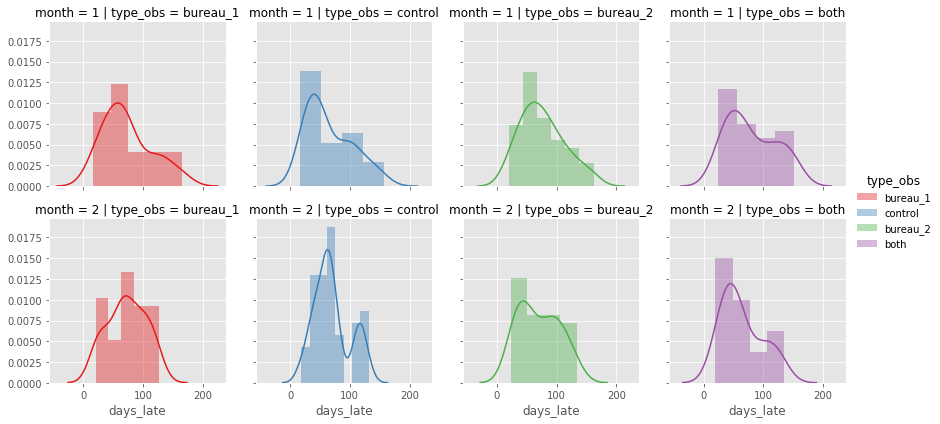

In [1026]:

g = sns.FacetGrid(time,row='month', col="type_obs",hue="type_obs", palette="Set1")
g = (g.map(sns.distplot, 'days_late',hist=True))
g.add_legend()

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


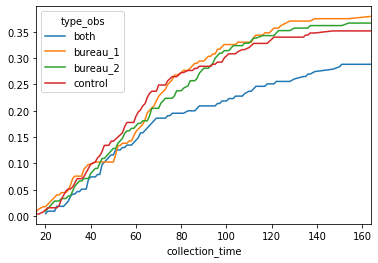

In [27]:
pars=base.loc[ max_date_obs['date']].groupby(
                                    ['type_obs'])['id'].count()
base.loc[ max_date_obs['date']  ][(pd.notna(base['collection__end'])) & (base['month']<3 ) ]  .groupby(['type_obs','collection_time'])['id'].count().unstack().T.div(pars).cumsum().fillna(method='ffill').plot()

In [28]:
max_date_obs_0=base[base['days_late']>=0].groupby('id')['date'].idxmax().reset_index()
min_date_obs_0=base[base['id'].isin(max_date_obs['id'])].groupby('id')['date'].idxmin().reset_index()

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


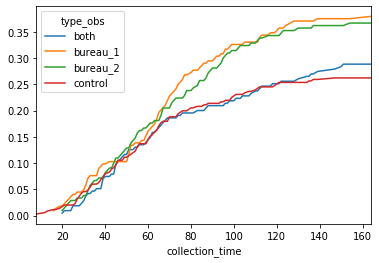

In [29]:
pars=base.loc[ max_date_obs_0['date']].fillna(0).groupby(['type_obs'])['id'].count()
base.loc[ max_date_obs_0['date']][ (pd.notna(base['collection__end']))  & (base['month']<3 ) ]  .groupby(['type_obs','collection_time'])['id'].count().unstack().T.div(pars).cumsum().fillna(method='ffill').plot()

### Hypotesis, reports to the bureaus change the probability of repayment ->logistic model with interaction effects, controls and  a fixed time windows
### Hypotesis, reports to the bureaus don't change the effort to pay monthly therefore  late_payments  per week following the intervention don't change


In [30]:
 logit_mod = sm.Logit(spector_data.endog, spector_data.exog)
logit_res = logit_mod.fit()
print(logit_res.summary())
ffair_mod = logit("affair ~ occupation + educ + occupation_husb"
                   "+ rate_marriage + age + yrs_married + children"
                   " + religious", dta).fit(
affair_mod.pred_table()
margeff = logit_res.get_margeff()
print(margeff.summary())

SyntaxError: invalid syntax (<ipython-input-30-fa07ab6d27c1>, line 8)

### There is a need to discretize time,because there is an aspect of survival analysis.Not every observation had the chance to be 90 days old

### The problem formulation is as such, given that the observations could have recieved the treatment, (where at least 17 days overdue), and given the time of the database could be observed to at least 80 days.
### In other words whats the probability that the  m1over17 observations turn into 80days late given the treatments
### I choose 80 days because there appears to be where the series diverge

In [31]:
print(base['date'].min())
print(base['date'].max())

2017-01-01 00:00:00
2017-06-15 00:00:00


In [273]:
base['date'].max()-pd.Timedelta('90days')

Timestamp('2017-03-17 00:00:00')

In [345]:
logistic_reference=base[(base['days_late']==17) & (base['collections_start']<'2017-03-17')].drop(['days_late'],axis=1)

In [381]:
logistic_reference['logistic_target']=0
logistic_reference.loc[logistic_reference['collection_time']<=90  , 'logistic_target'] = 1
logistic_reference.loc[logistic_reference['type_obs'].isin(['both','bureau_1']) ,  'bureau_1']=1

In [379]:
logistic_reference.groupby(['logistic_target','type_obs']) ['id'] .count()

logistic_target  type_obs
0                both        51
                 bureau_1    69
                 bureau_2    68
                 control     65
1                both        42
                 bureau_1    41
                 bureau_2    47
                 control     62
Name: id, dtype: int64

In [371]:
from statsmodels.formula.api import logit

In [372]:
base_discreta=pd.DataFrame()
for i in logistic_reference.select_dtypes(include='number').columns:
    try:
        base_discreta[i]=pd.qcut(logistic_reference[i].fillna(0),10,duplicates='drop')
    except: 
        continue

In [373]:
base_discreta['logistic_target']=logistic_reference['logistic_target']

In [374]:
from IPython.display import display

logistic_target    0    1
bureau_2                 
(-0.001, 1.0]    137  308


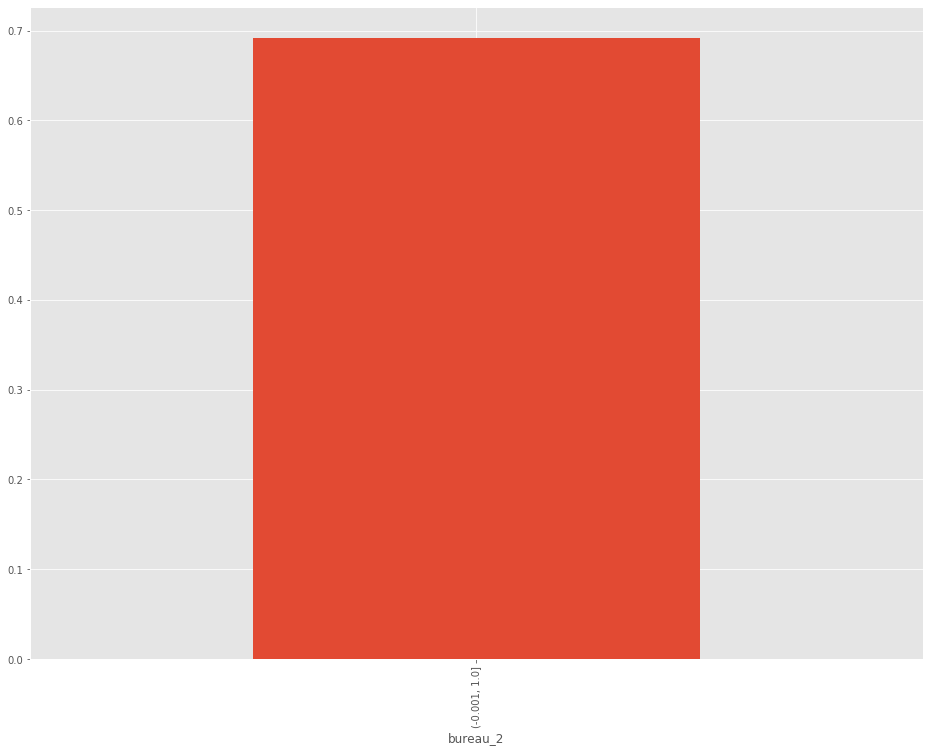

logistic_target   0    1
late_payments           
(-0.001, 10.0]   97  228
(10.0, 20.0]     14   29
(20.0, 40.0]     14   24
(40.0, 250.0]    12   27


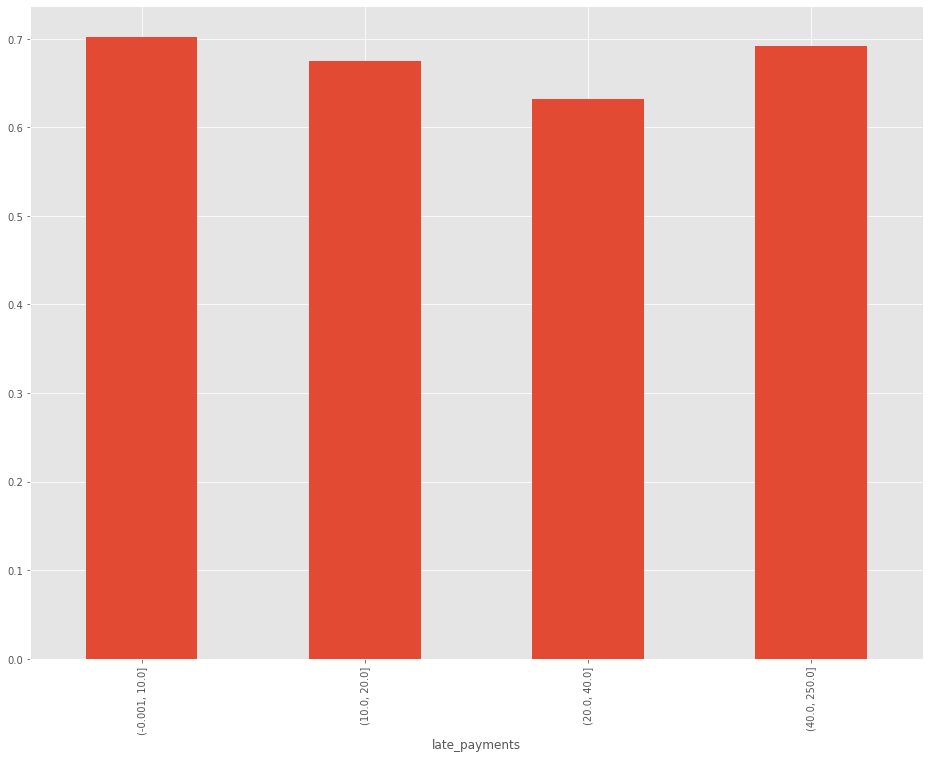

logistic_target            0   1
std_revolving_balance_30        
(-1.001, 1.0]             28  42
(1.0, 2.0]                19  39
(2.0, 3.0]                21  42
(3.0, 4.0]                14  31
(4.0, 5.0]                11  24
(5.0, 7.0]                15  42
(7.0, 9.0]                 4  29
(9.0, 14.0]               15  27
(14.0, 313.0]             10  32


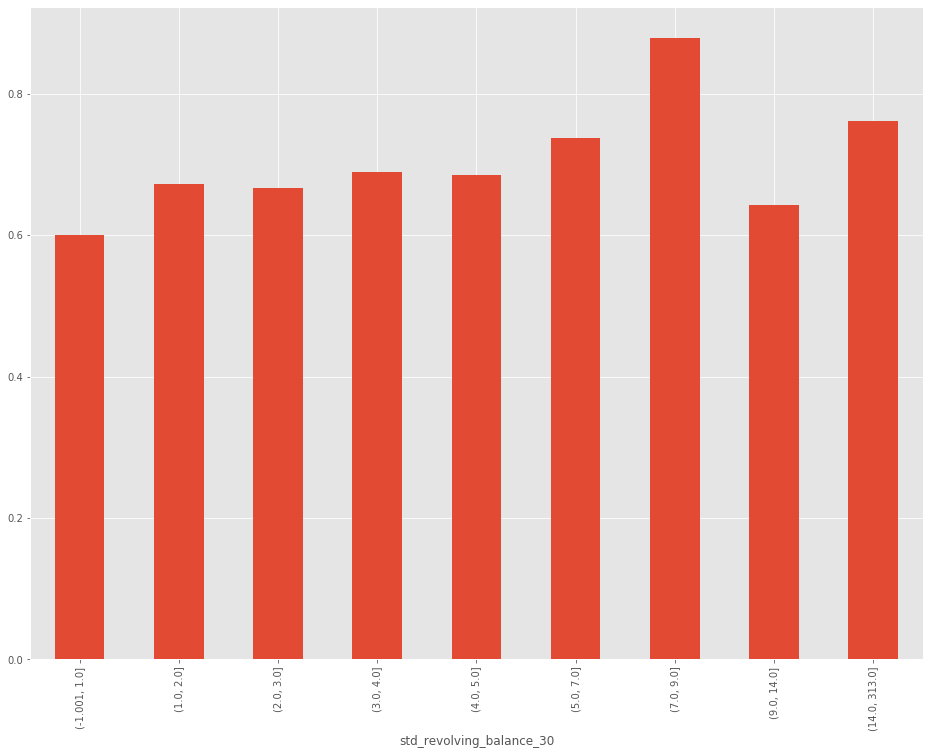

logistic_target          0    1
agreement_amount_mean          
(-0.001, 1044.8]       127  273
(1044.8, 6188.0]        10   35


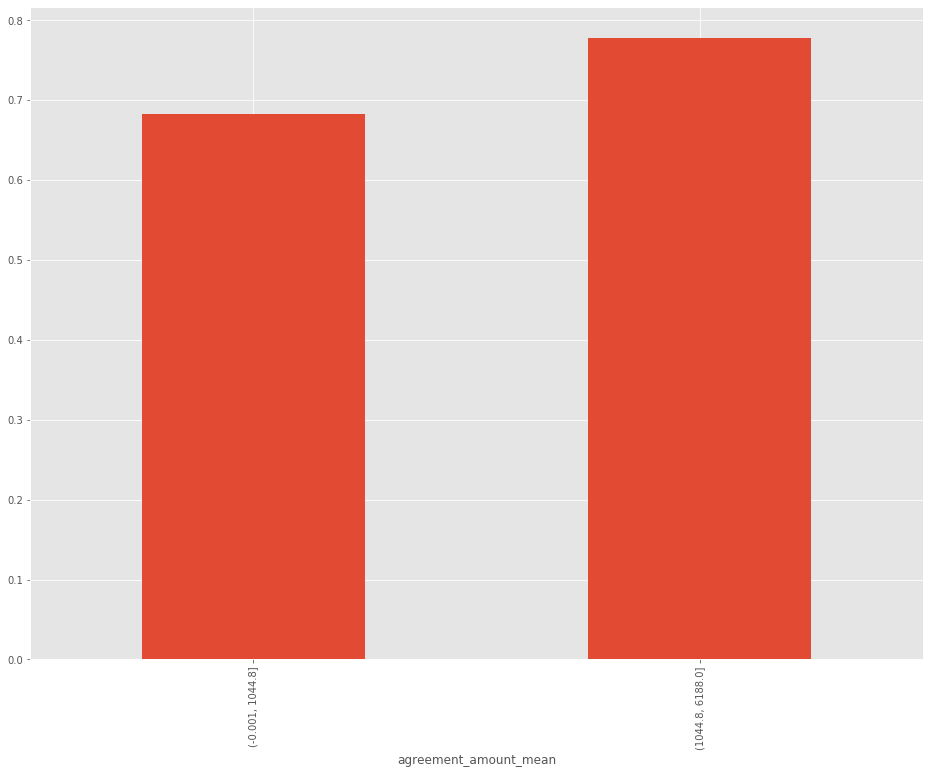

logistic_target                0   1
oustanting_balance_weight_30        
(-39.001, 20.4]               15  30
(20.4, 38.0]                  19  38
(38.0, 52.0]                  10  23
(52.0, 71.6]                   8  35
(71.6, 88.0]                  17  28
(88.0, 118.4]                 16  28
(118.4, 157.8]                15  29
(157.8, 308.6]                 8  37
(308.6, 534.0]                13  31
(534.0, 6864.0]               16  29


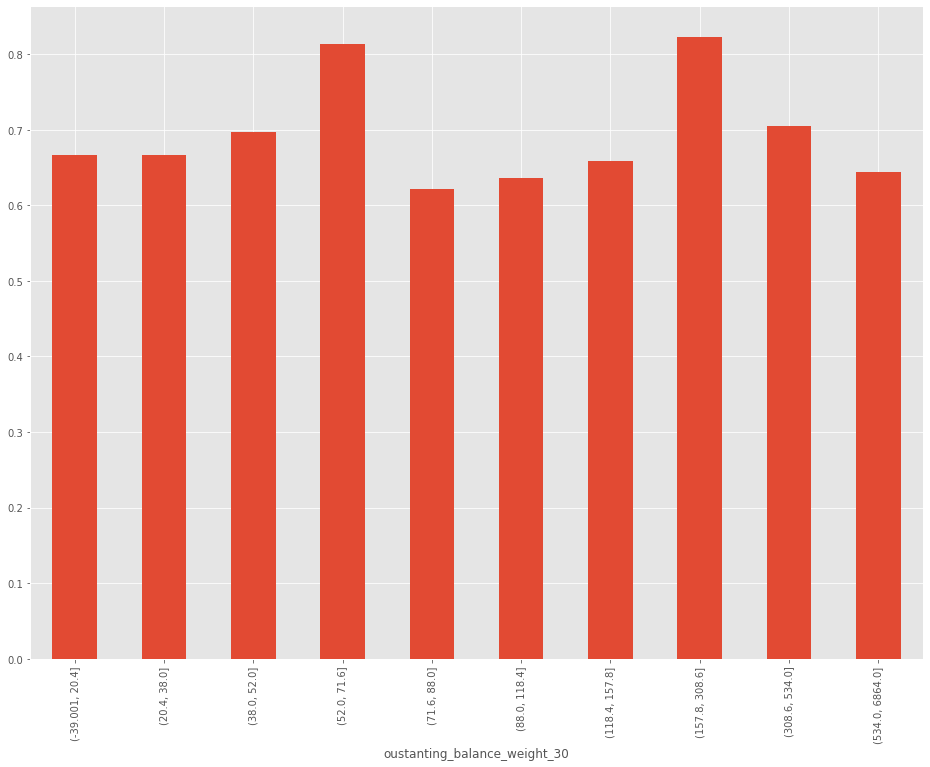

logistic_target                0   1
oustanting_balance_weight_90        
(-0.001, 2.0]                 47  91
(2.0, 4.0]                    22  42
(4.0, 5.0]                    12  21
(5.0, 7.0]                    10  23
(7.0, 11.0]                   13  48
(11.0, 16.0]                  11  23
(16.0, 24.6]                  10  27
(24.6, 175.0]                 12  33


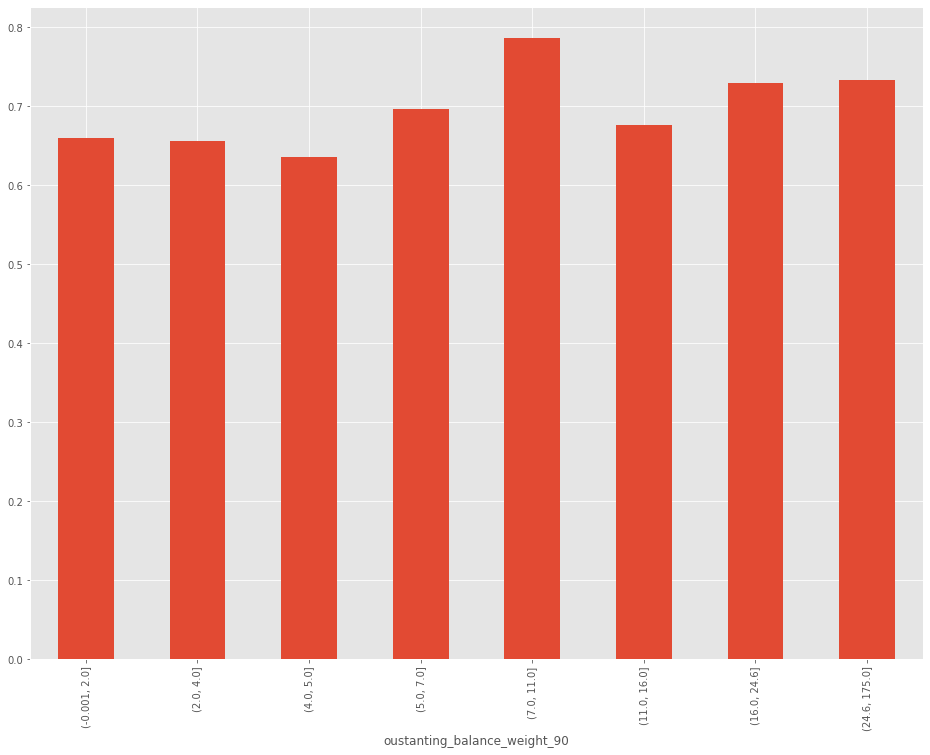

logistic_target               0    1
max_installments_balance_90         
(-0.001, 1.0]                76  152
(1.0, 2.4]                   10   29
(2.4, 4.8]                   10   34
(4.8, 11.0]                  15   32
(11.0, 23.6]                 15   27
(23.6, 447.0]                11   34


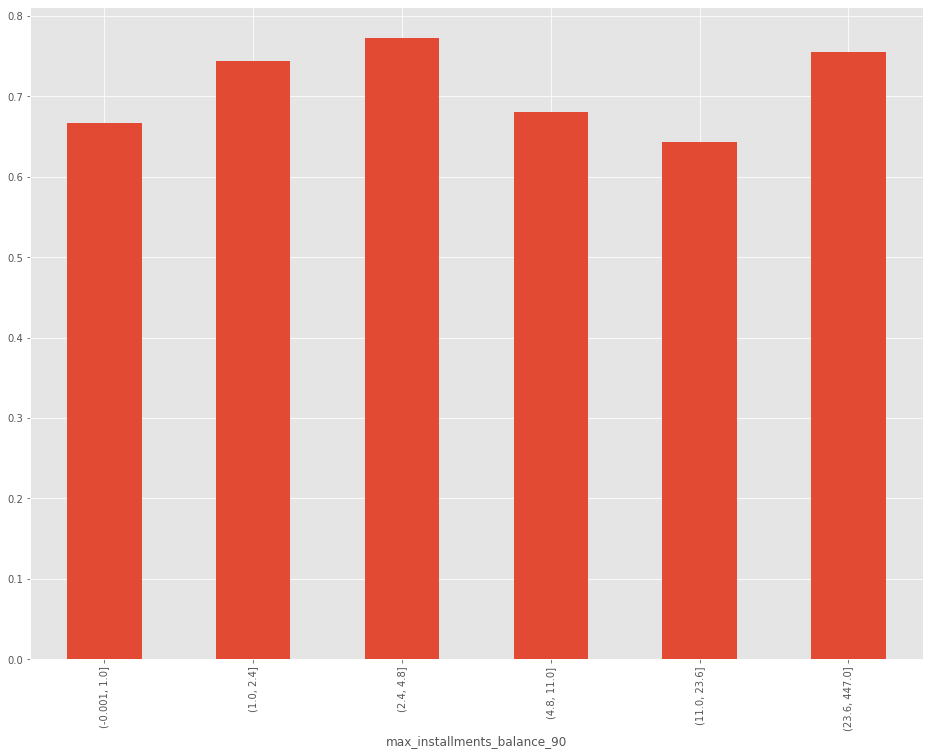

logistic_target     0   1
max_payment_90           
(-516.001, 249.2]  14  31
(249.2, 530.4]     18  26
(530.4, 857.8]     14  31
(857.8, 1282.2]    16  28
(1282.2, 1898.0]   11  34
(1898.0, 2552.4]   15  29
(2552.4, 3461.8]   10  34
(3461.8, 5178.6]   10  35
(5178.6, 9598.6]   15  29
(9598.6, 78849.0]  14  31


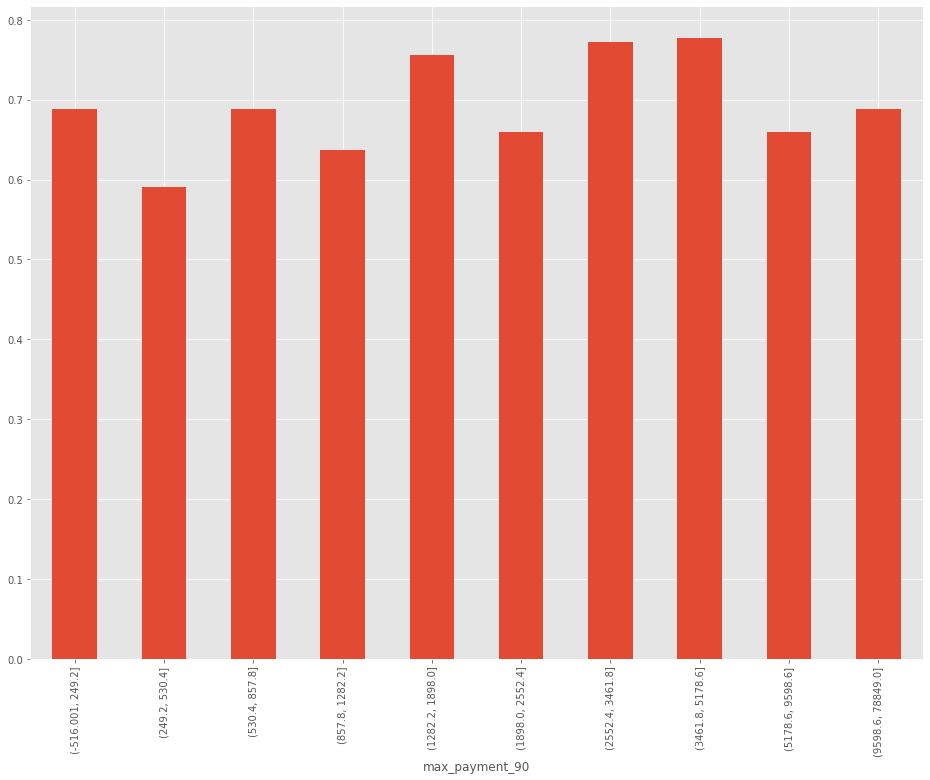

logistic_target                      0    1
sum_limit_request_time_weight_180          
(-0.001, 1.0]                      131  283
(1.0, 3.0]                           6   25


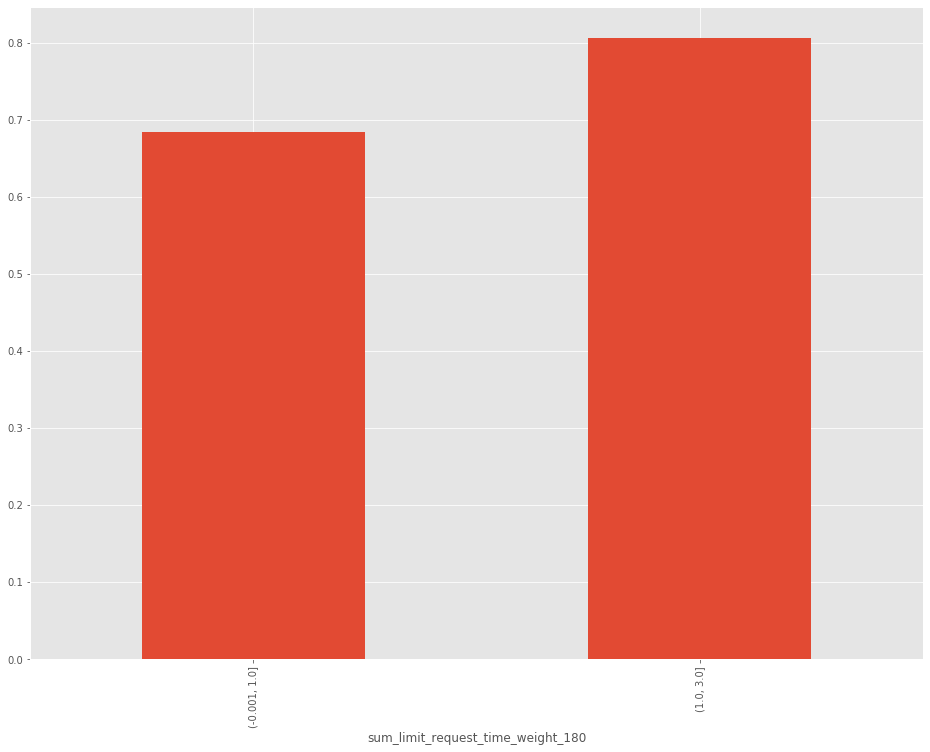

logistic_target    0   1
loss_balance            
(-0.001, 9.0]     23  55
(9.0, 10.0]        2  11
(10.0, 16.0]      22  38
(16.0, 17.0]       9  20
(17.0, 24.0]      13  31
(24.0, 37.0]      13  32
(37.0, 62.0]      16  27
(62.0, 161.8]      6  38
(161.8, 423.6]    16  28
(423.6, 26985.0]  17  28


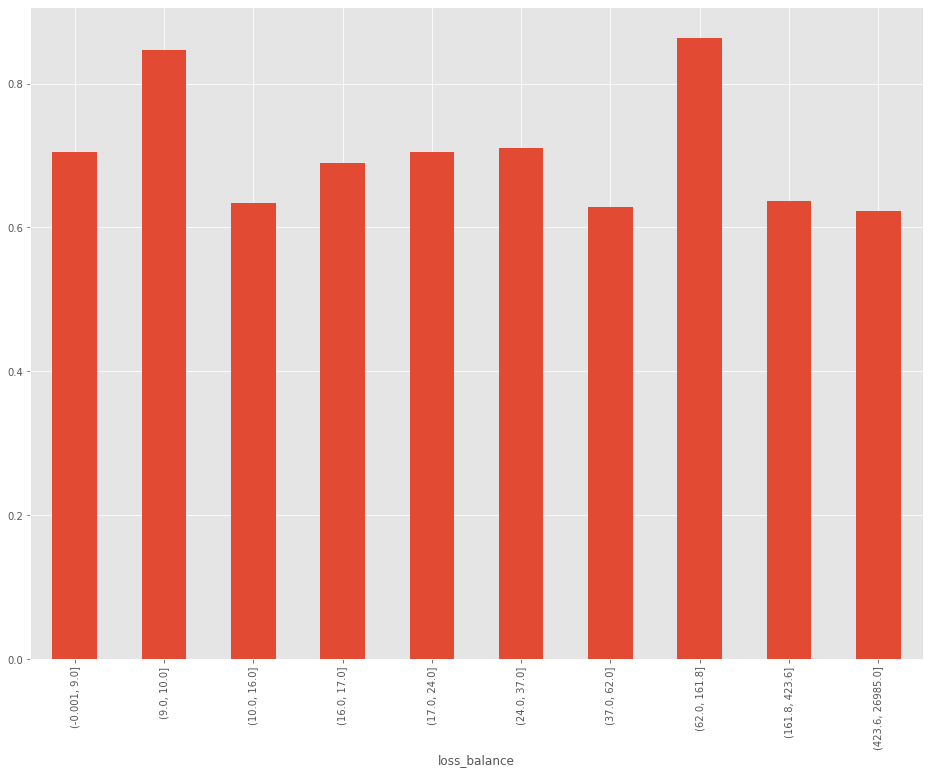

logistic_target          0   1
avg_late_balance_0_180        
(15.999, 29.0]          18  30
(29.0, 44.0]            19  23
(44.0, 101.0]           18  27
(101.0, 116.0]          10  34
(116.0, 132.0]          13  33
(132.0, 197.4]          13  29
(197.4, 300.0]          12  32
(300.0, 460.6]          13  32
(460.6, 770.6]           8  36
(770.6, 12291.0]        13  32


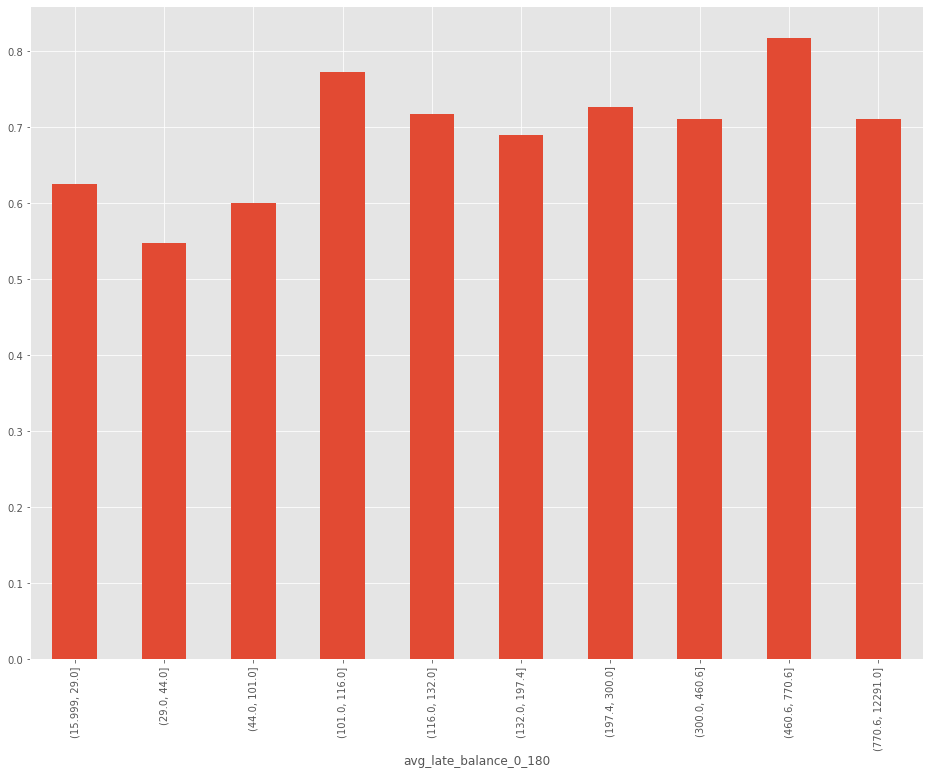

logistic_target    0    1
email_event_30           
(-0.001, 1.0]    137  308


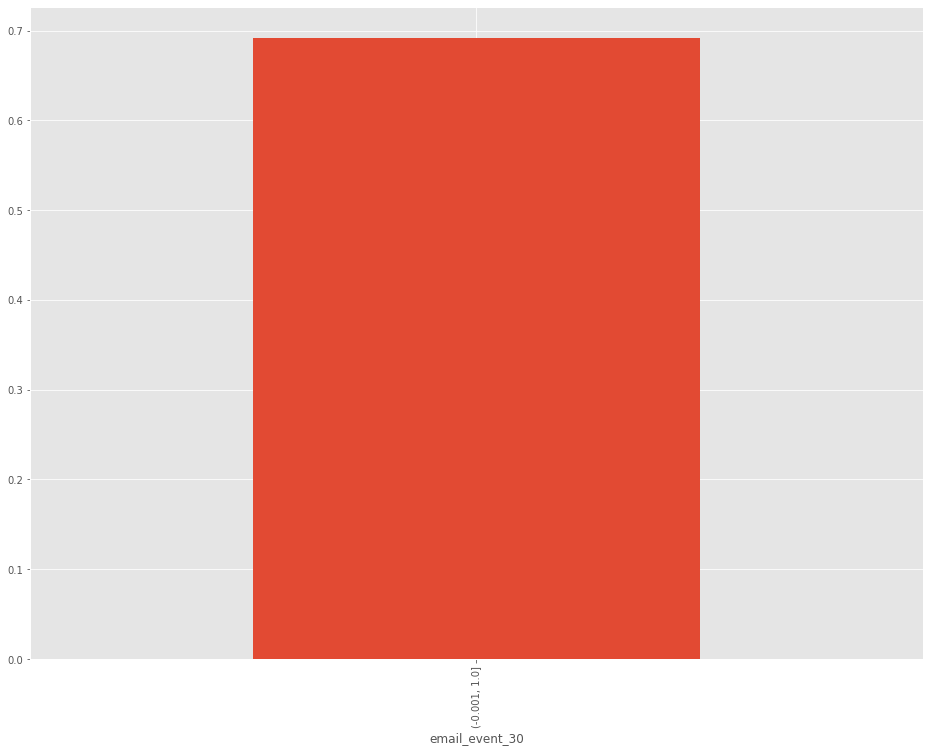

logistic_target                  0    1
count_inbound_call_inbound_30          
(-0.001, 1.0]                  137  308


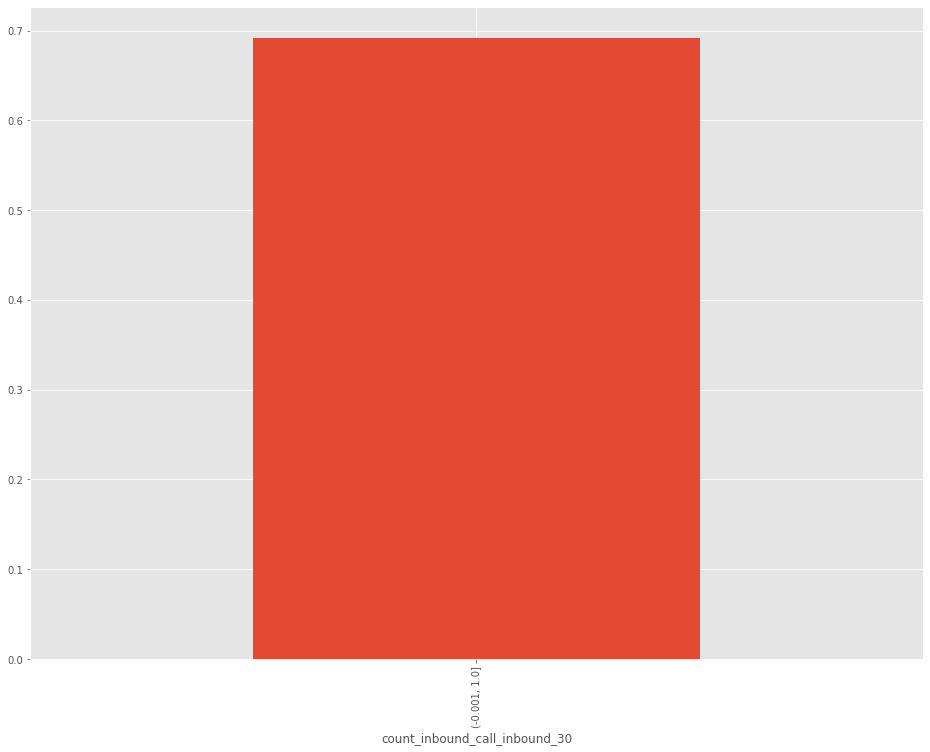

logistic_target        0    1
avg_call_duration_30         
(-0.001, 1.0]         84  160
(1.0, 2.0]            22   57
(2.0, 3.0]            14   34
(3.0, 5.0]            12   33
(5.0, 49.0]            5   24


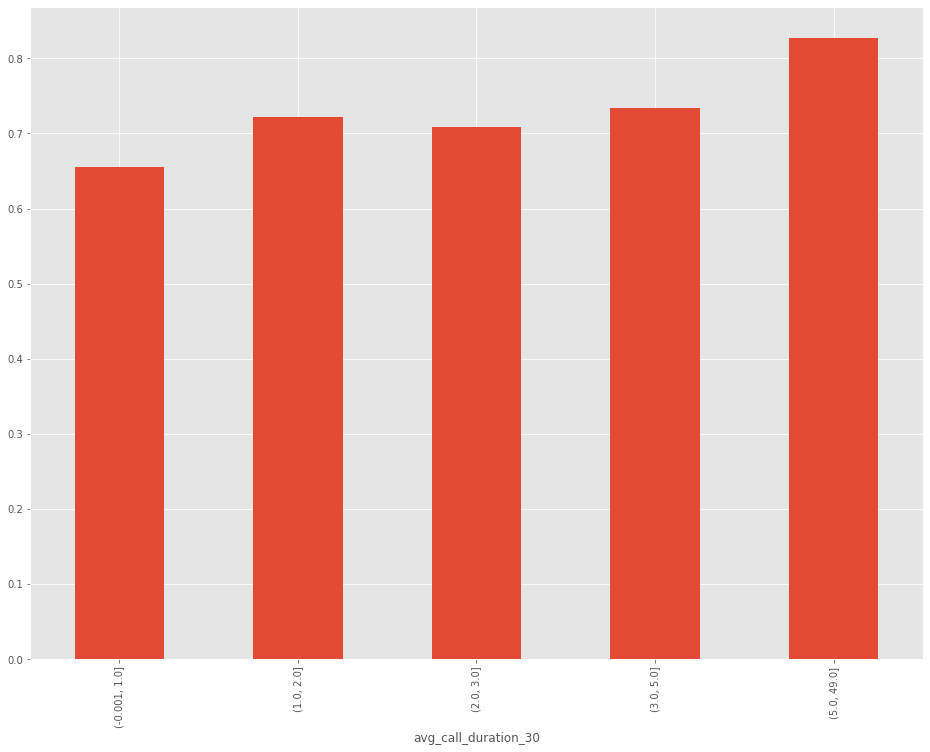

logistic_target               0    1
avg_installments_balance_30         
(-0.001, 1.0]                75  169
(1.0, 2.0]                   24   39
(2.0, 3.0]                   12   29
(3.0, 4.0]                    3   16
(4.0, 7.6]                   10   23
(7.6, 117.0]                 13   32


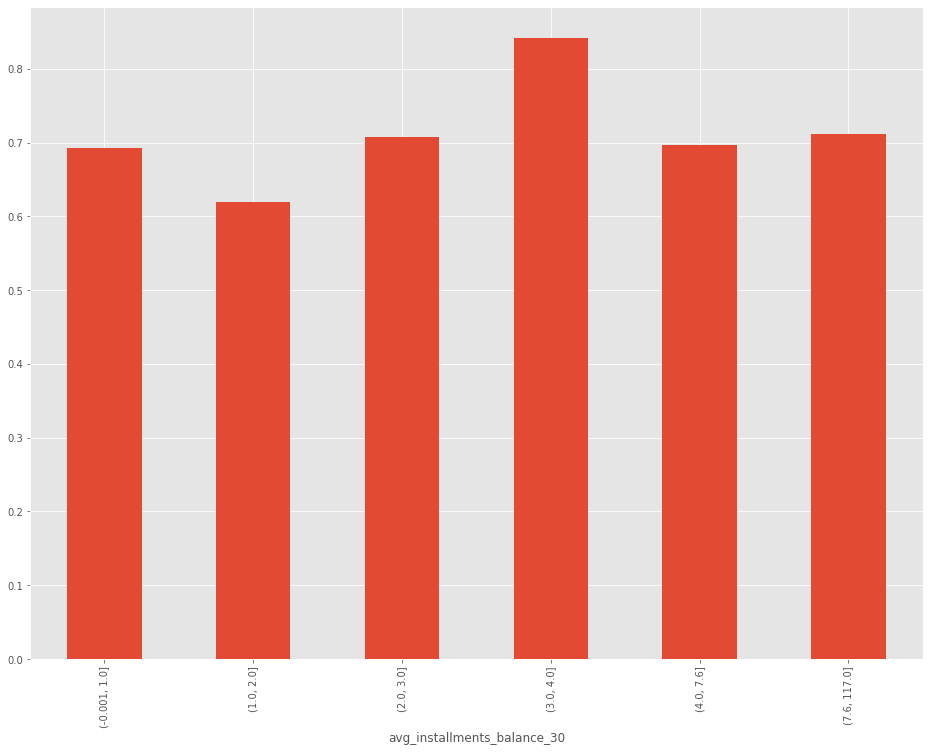

logistic_target           0    1
charges_agreement_mean          
(-0.001, 4.0]           127  277
(4.0, 22.0]              10   31


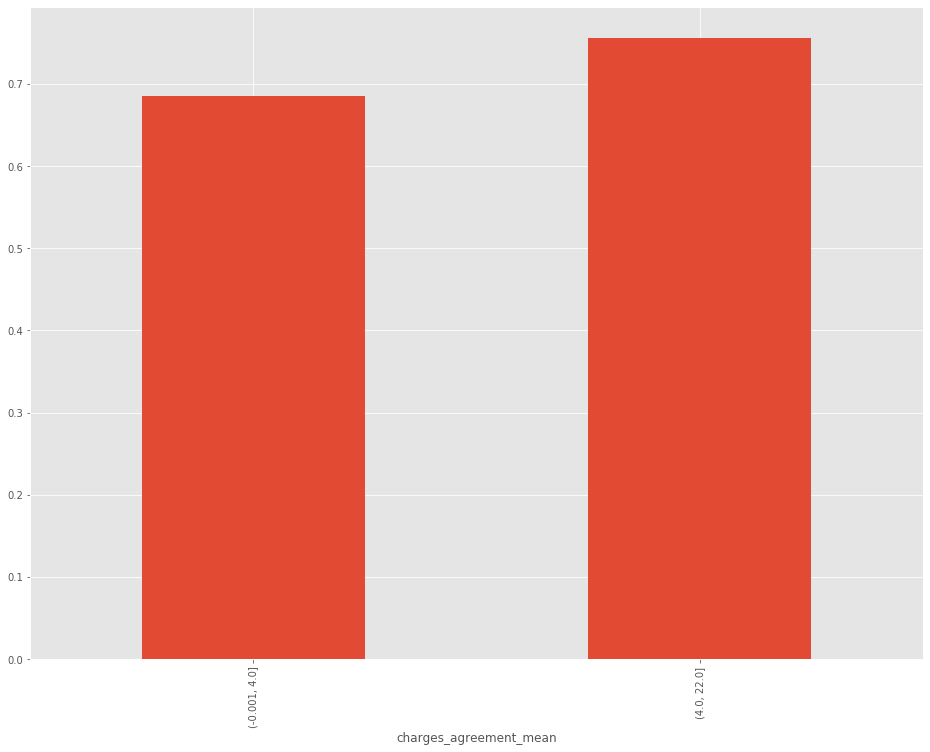

logistic_target             0    1
ongoing_agreement_amount          
(-0.001, 4512.0]          137  308


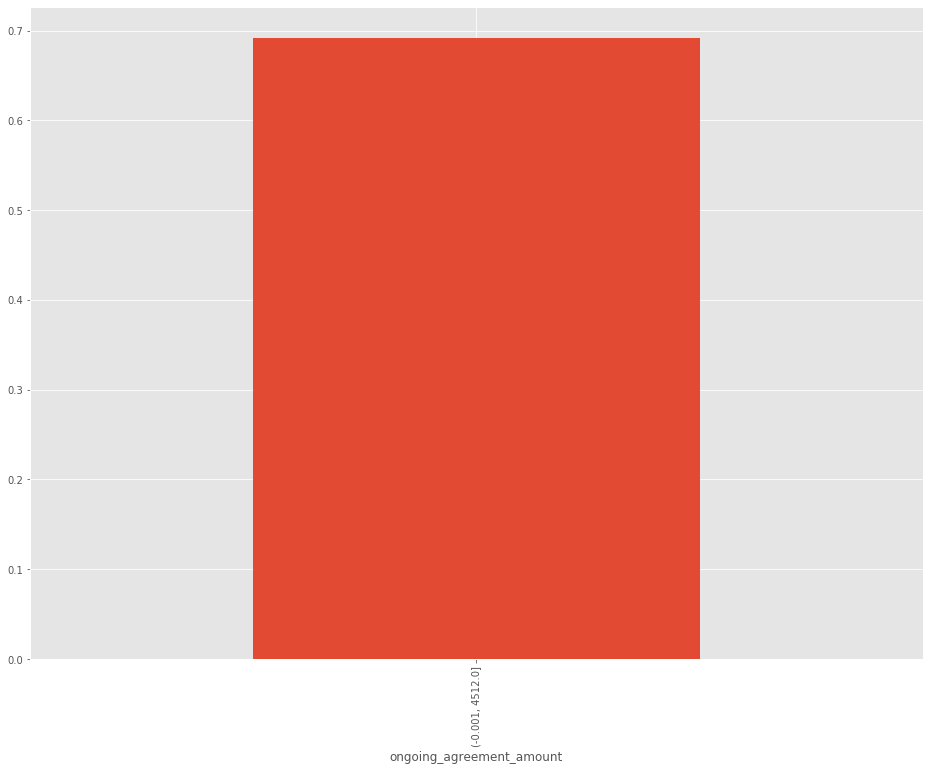

logistic_target      0   1
asset_late_balance        
(-33.001, 0.0]      20  42
(0.0, 4.0]          16  24
(4.0, 9.2]          12  20
(9.2, 35.0]         20  28
(35.0, 58.0]        14  29
(58.0, 103.4]        7  35
(103.4, 229.4]      13  31
(229.4, 469.6]       9  36
(469.6, 1499.0]     12  32
(1499.0, 53256.0]   14  31


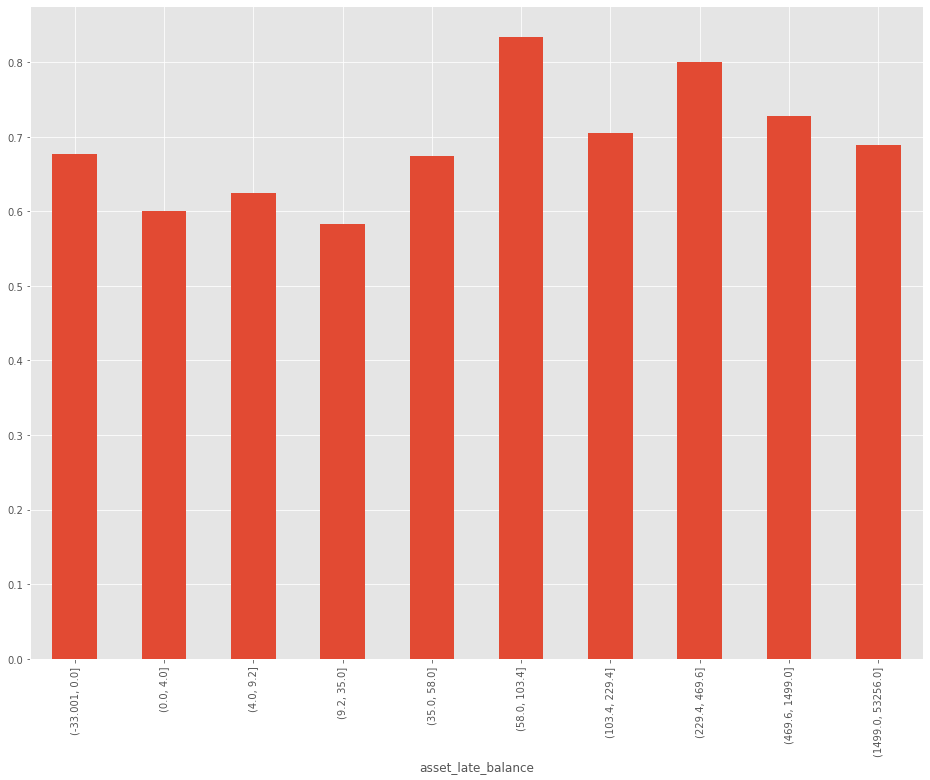

logistic_target                  0    1
ongoing_agreement_downpayment          
(-0.001, 692.0]                137  308


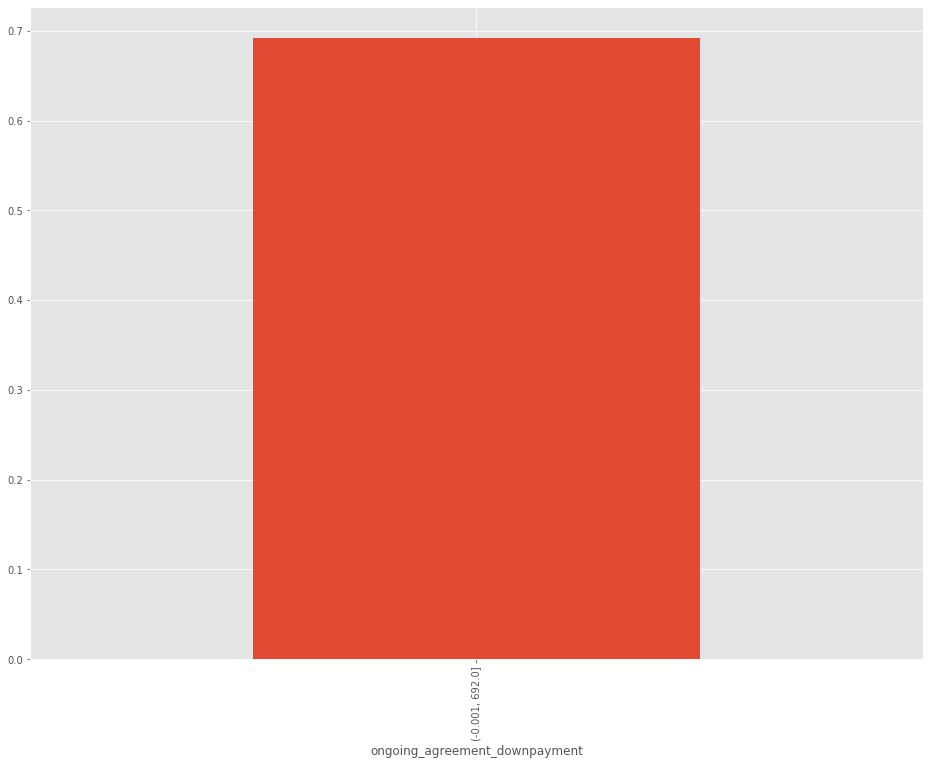

logistic_target    0    1
recovery_balance         
(-0.001, 1.0]     87  197
(1.0, 2.0]        27   62
(2.0, 3.0]        10   25
(3.0, 25.0]       13   24


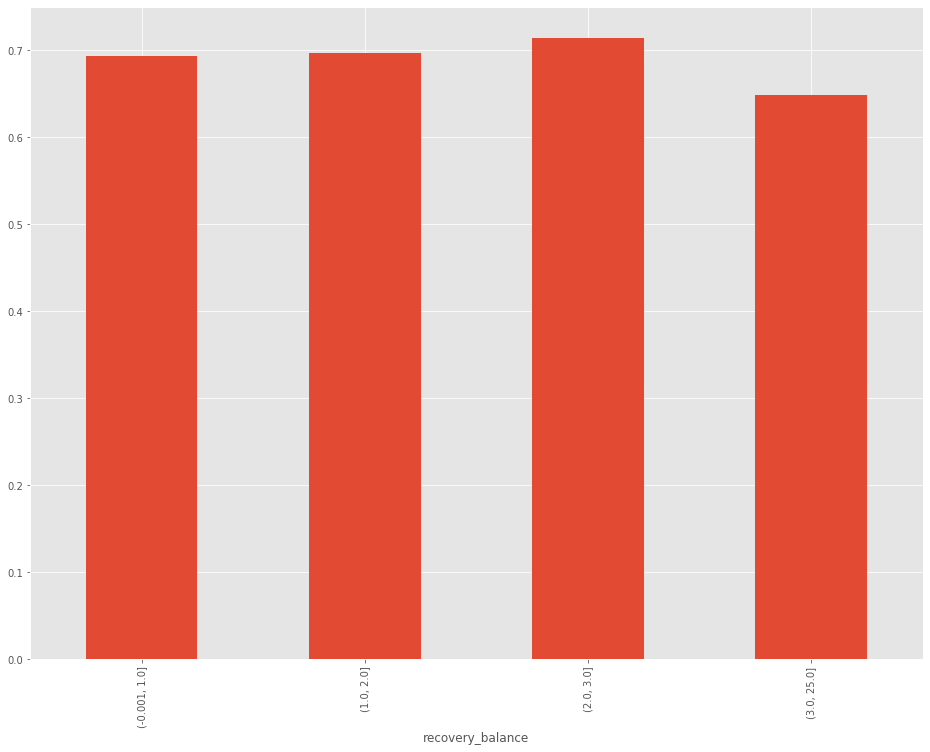

logistic_target                 0    1
std_installments_balance_0_90         
(-0.001, 1.0]                  81  168
(1.0, 2.0]                      8   26
(2.0, 3.8]                      7   21
(3.8, 7.0]                     16   32
(7.0, 13.6]                    14   27
(13.6, 175.0]                  11   34


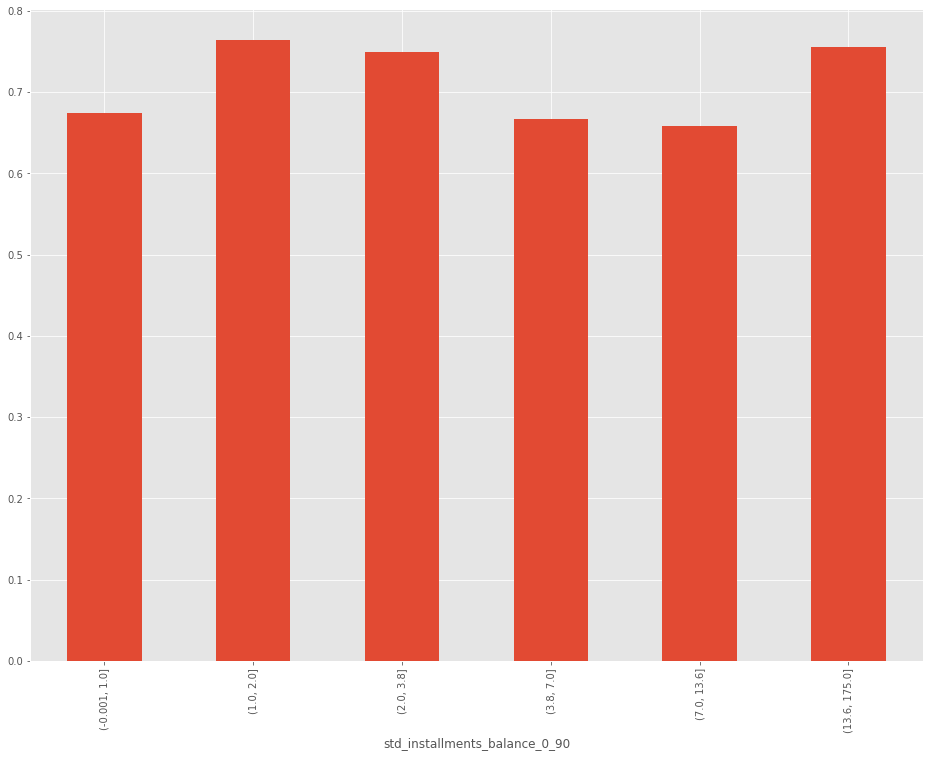

logistic_target         0    1
last_email_engagement         
(-0.001, 51.0]         63  161
(51.0, 86.0]           13   31
(86.0, 151.8]          13   30
(151.8, 204.4]         20   25
(204.4, 339.6]         19   25
(339.6, 2018.0]         9   36


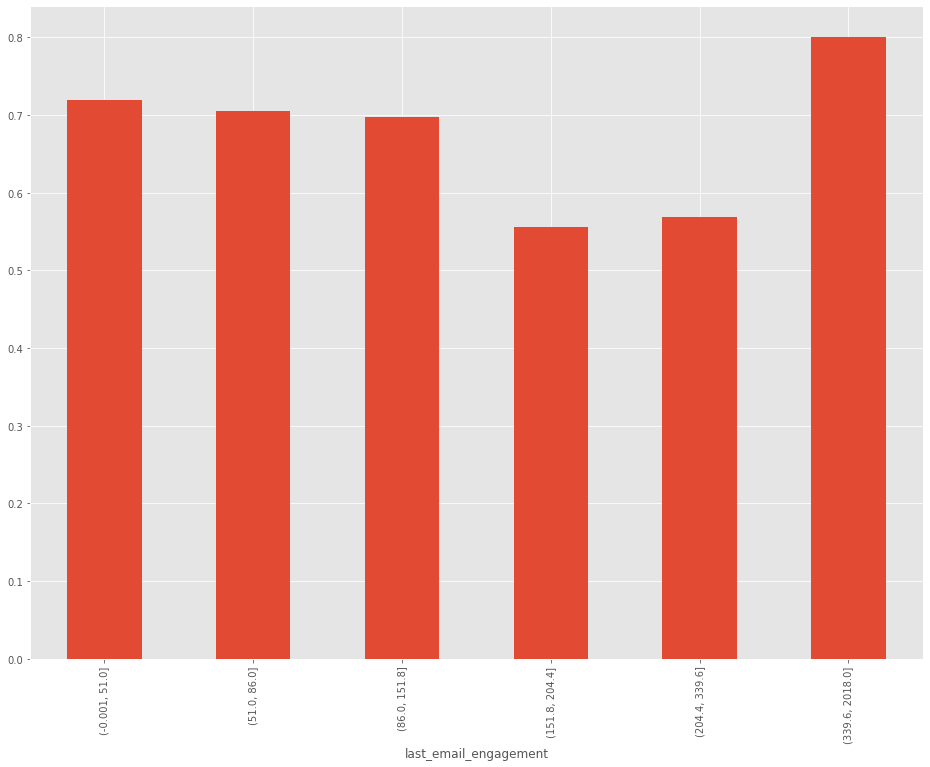

logistic_target        0    1
last_chat_engagement         
(-0.001, 26.0]        78  145
(26.0, 54.0]           9   37
(54.0, 77.8]          11   31
(77.8, 102.0]         11   35
(102.0, 151.6]        13   30
(151.6, 1727.0]       15   30


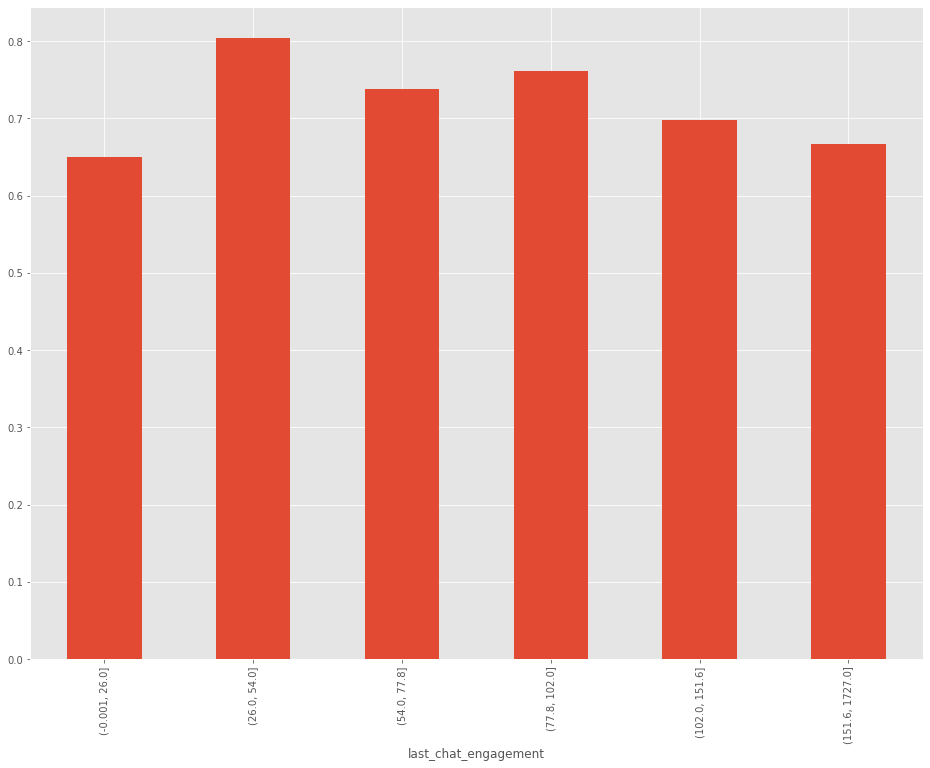

logistic_target          0    1
finantial_institutions         
(-0.001, 1.0]           59  124
(1.0, 2.0]              37   77
(2.0, 3.0]              20   41
(3.0, 5.0]              12   42
(5.0, 27.0]              9   24


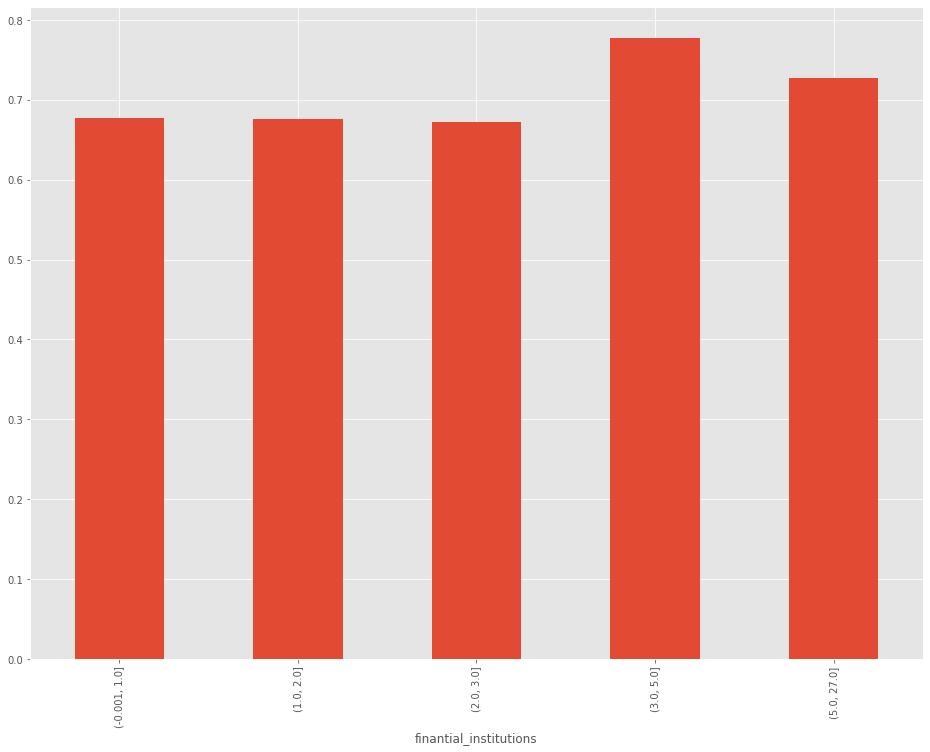

logistic_target     0    1
downpayment_mean          
(-0.001, 176.2]   125  275
(176.2, 1249.0]    12   33


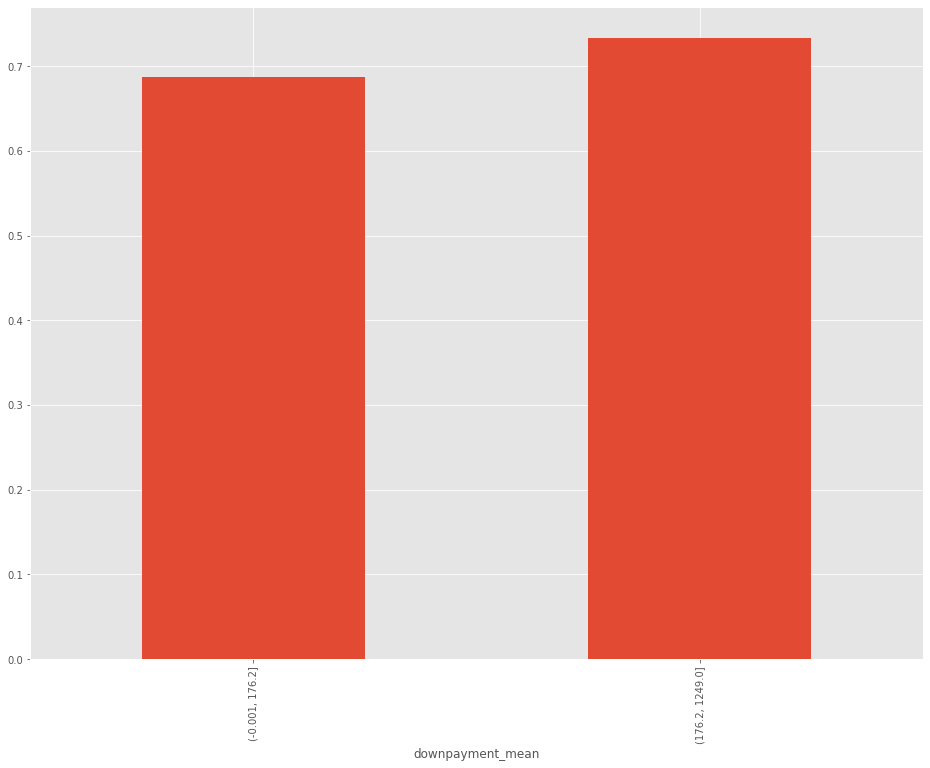

logistic_target    0    1
avg_spends               
(-0.001, 28.0]   104  210
(28.0, 69.6]      11   31
(69.6, 170.0]      8   36
(170.0, 1385.0]   14   31


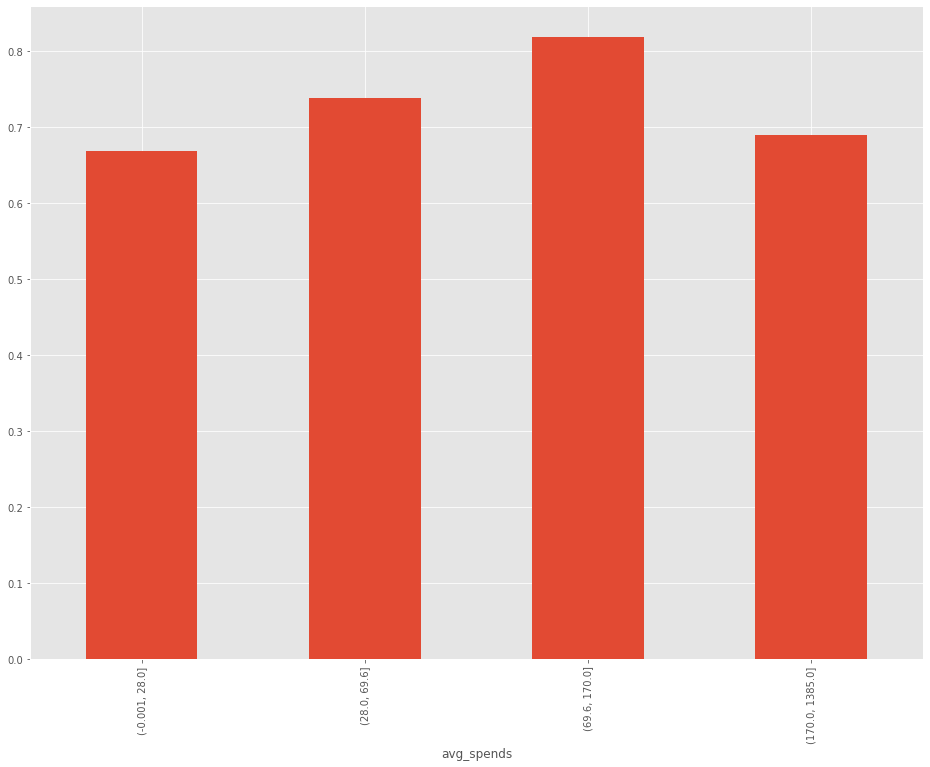

logistic_target   0   1
score_1                
(-0.001, 255.4]  14  31
(255.4, 337.2]   19  25
(337.2, 387.2]   13  32
(387.2, 433.8]    9  35
(433.8, 488.0]   14  31
(488.0, 549.0]   14  31
(549.0, 628.4]   12  31
(628.4, 721.8]    8  37
(721.8, 937.6]   18  26
(937.6, 3927.0]  16  29


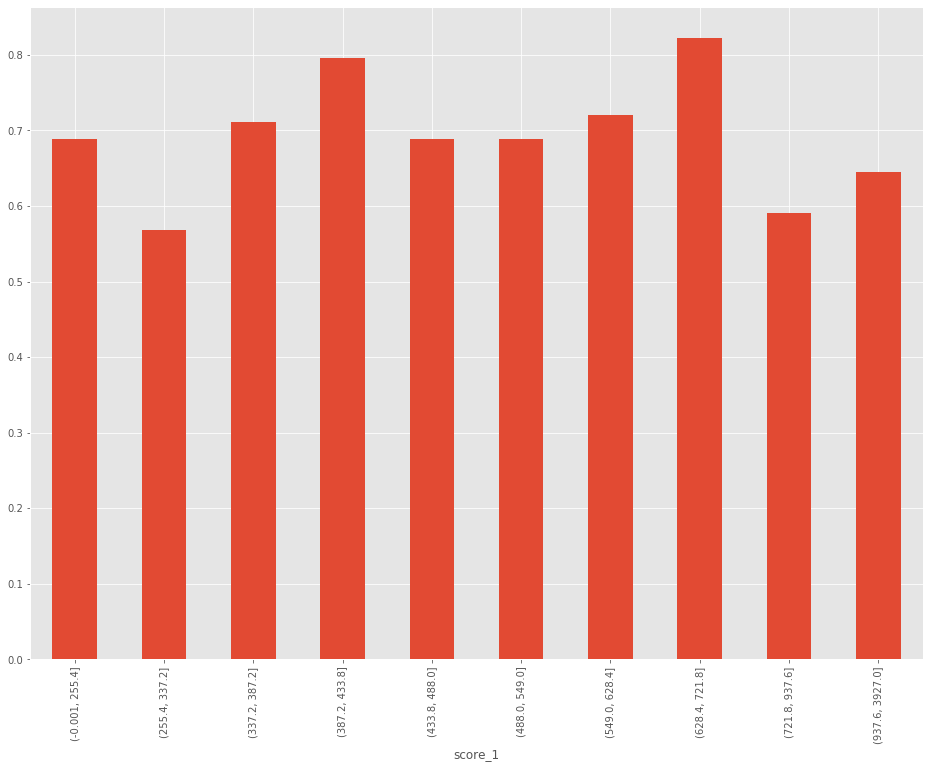

logistic_target   0   1
score_2                
(-0.001, 17.0]   14  33
(17.0, 29.8]     15  27
(29.8, 40.0]     13  34
(40.0, 52.0]     14  30
(52.0, 66.0]     17  26
(66.0, 83.0]     11  34
(83.0, 104.0]    11  34
(104.0, 146.2]   11  32
(146.2, 211.6]   12  32
(211.6, 765.0]   19  26


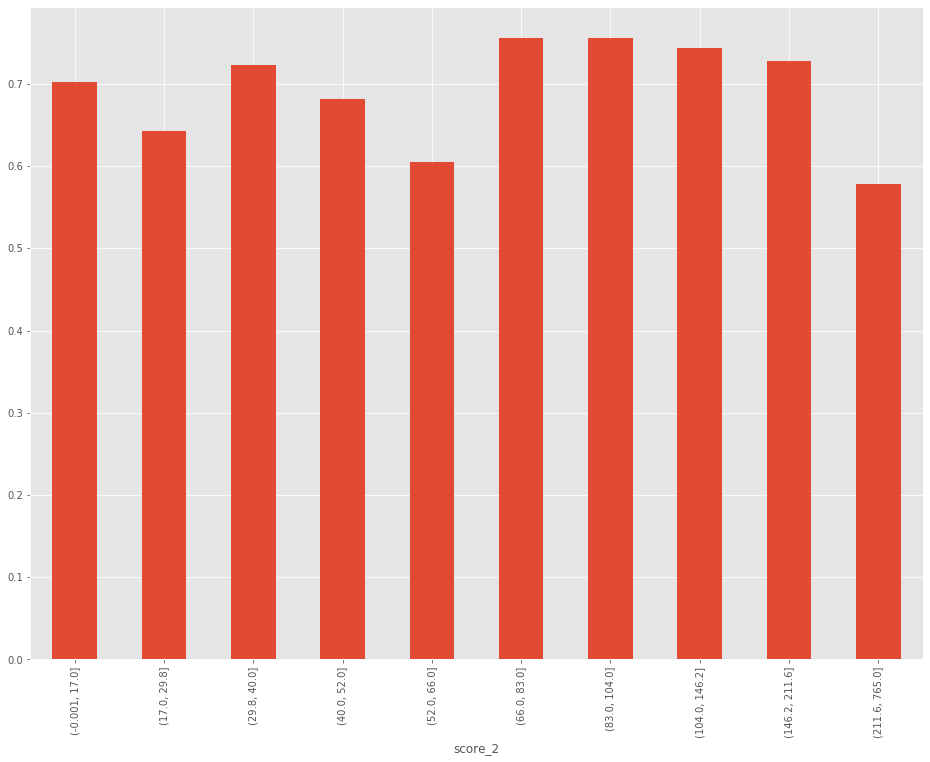

logistic_target   0   1
score_3                
(-0.001, 31.0]   13  33
(31.0, 47.8]     17  26
(47.8, 66.2]     13  32
(66.2, 87.6]     13  31
(87.6, 112.0]    15  30
(112.0, 133.0]    9  38
(133.0, 172.8]   14  27
(172.8, 228.6]   11  34
(228.6, 328.2]   15  29
(328.2, 1102.0]  17  28


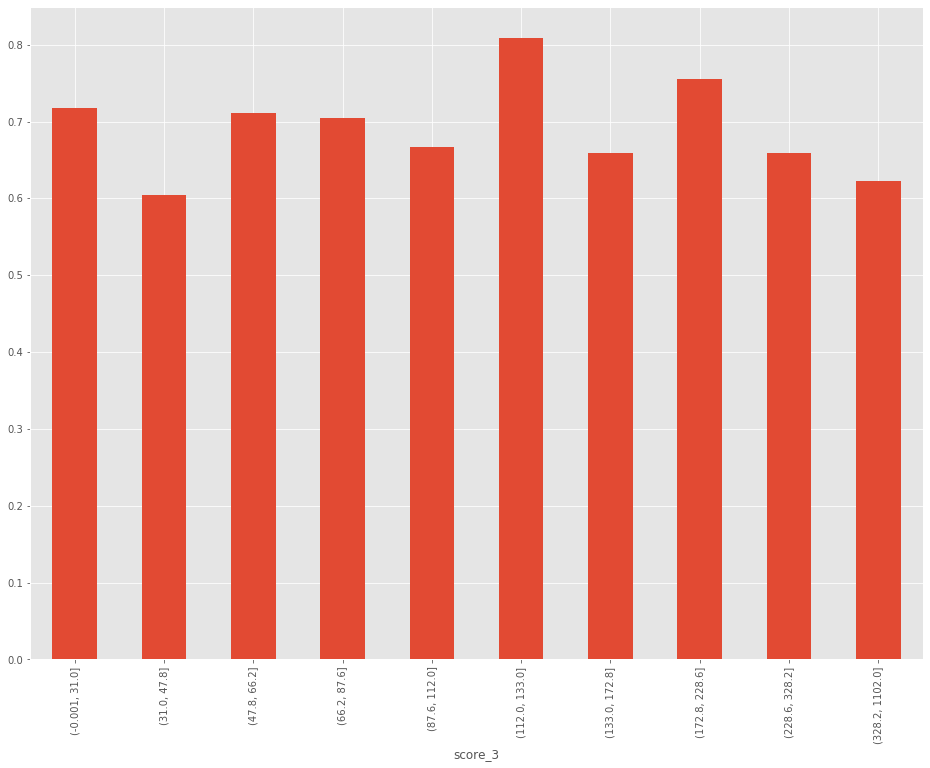

logistic_target     0   1
income_score_1           
(-0.001, 730.0]    16  29
(730.0, 941.4]     11  33
(941.4, 1140.2]    13  32
(1140.2, 1330.2]   15  29
(1330.2, 1608.0]   10  35
(1608.0, 1841.0]   13  31
(1841.0, 2232.8]   10  34
(2232.8, 2736.6]   24  21
(2736.6, 3518.6]    7  37
(3518.6, 12764.0]  18  27


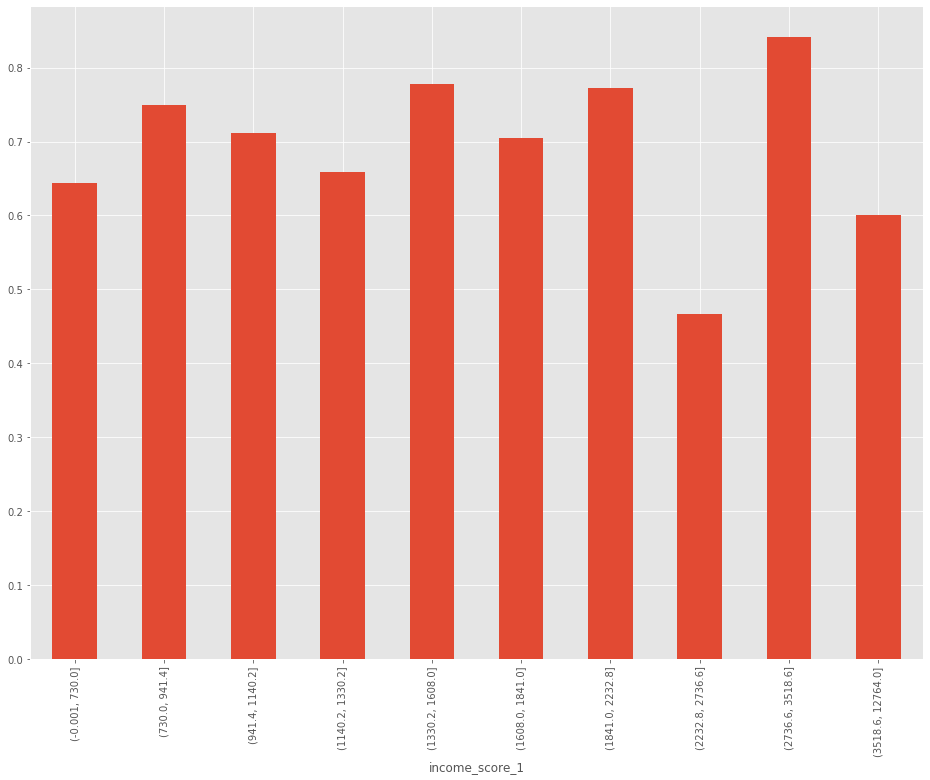

logistic_target                0   1
count_previous_delinquencies        
(-0.001, 1.0]                 29  64
(1.0, 2.0]                    35  56
(2.0, 3.0]                    22  65
(3.0, 4.0]                    19  40
(4.0, 5.0]                    15  32
(5.0, 6.0]                     5  20
(6.0, 14.0]                   12  31


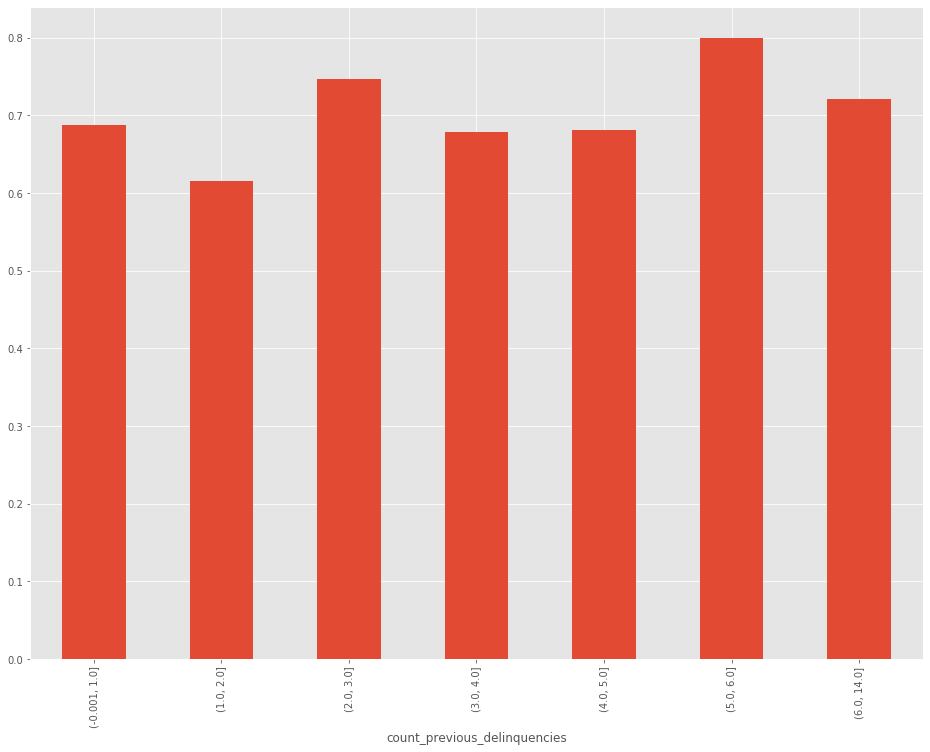

logistic_target     0   1
income_score_2           
(117.999, 803.4]   10  35
(803.4, 1129.0]    11  33
(1129.0, 1590.8]   23  22
(1590.8, 2026.2]   12  32
(2026.2, 2481.0]   14  31
(2481.0, 3237.0]   12  32
(3237.0, 4447.8]   10  34
(4447.8, 5764.4]   16  29
(5764.4, 8986.2]   12  32
(8986.2, 23732.0]  17  28


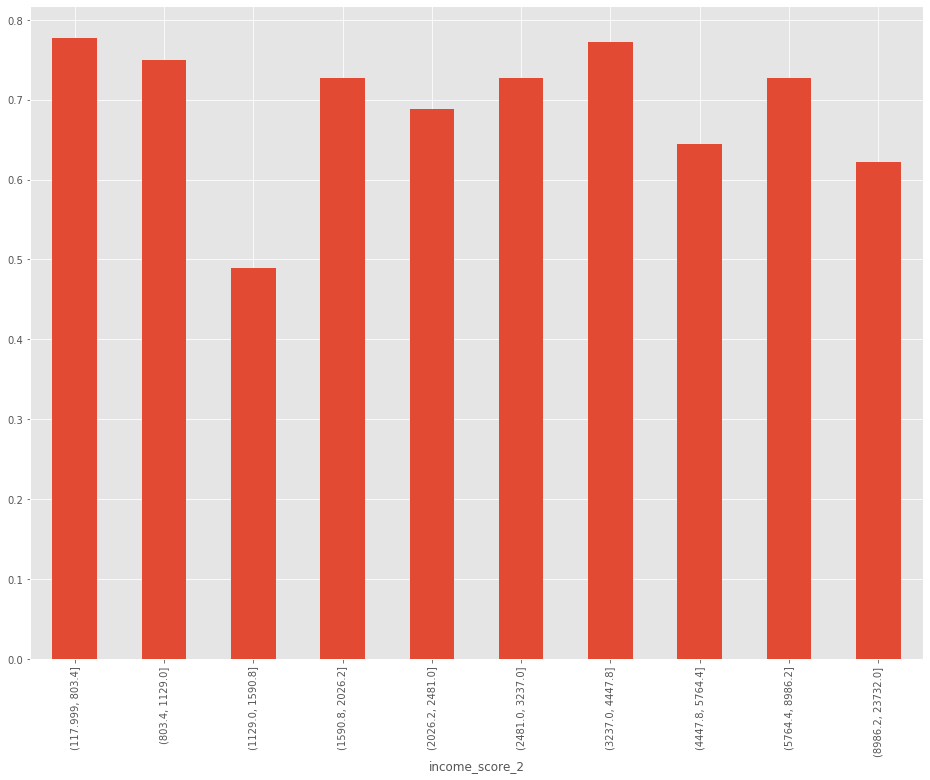

logistic_target   0   1
age                    
(22.999, 31.0]   14  44
(31.0, 33.0]     11  25
(33.0, 35.0]      8  36
(35.0, 37.0]     13  32
(37.0, 40.0]     20  32
(40.0, 42.0]     16  19
(42.0, 45.0]     18  45
(45.0, 47.0]      9  15
(47.0, 52.0]     13  32
(52.0, 74.0]     15  28


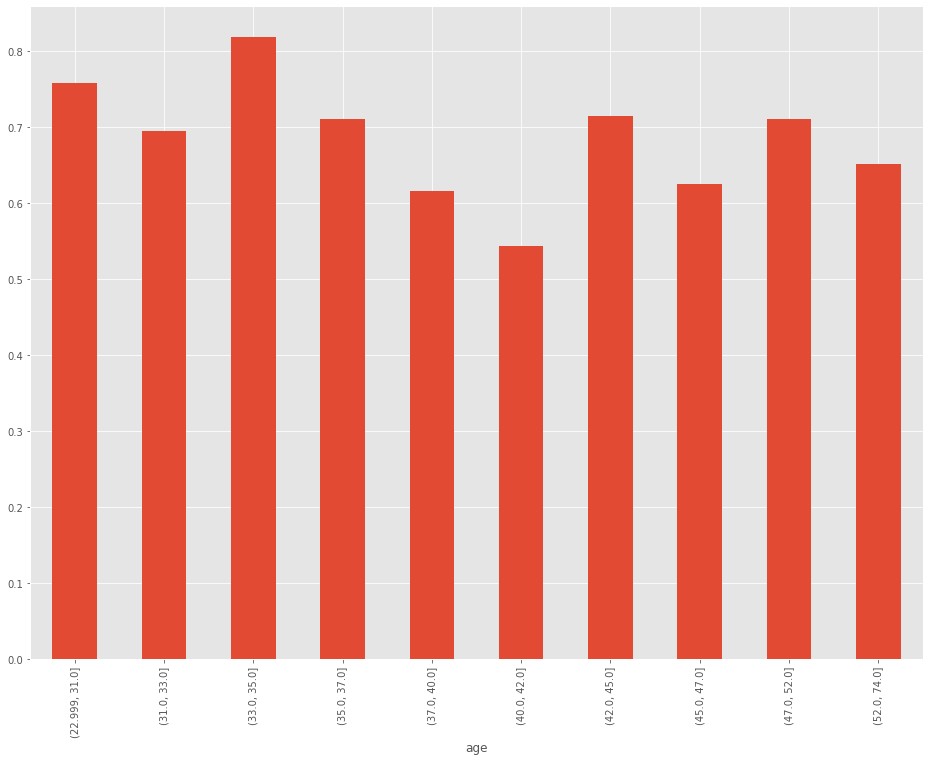

logistic_target                                 0   1
mean_previous_delinquencies_amount_weight_180        
(-0.001, 10.4]                                 14  31
(10.4, 50.0]                                   19  44
(50.0, 54.0]                                   14  15
(54.0, 66.2]                                   15  26
(66.2, 83.0]                                   13  32
(83.0, 128.4]                                  17  27
(128.4, 344.8]                                  8  36
(344.8, 573.2]                                 12  33
(573.2, 1266.8]                                11  33
(1266.8, 28346.0]                              14  31


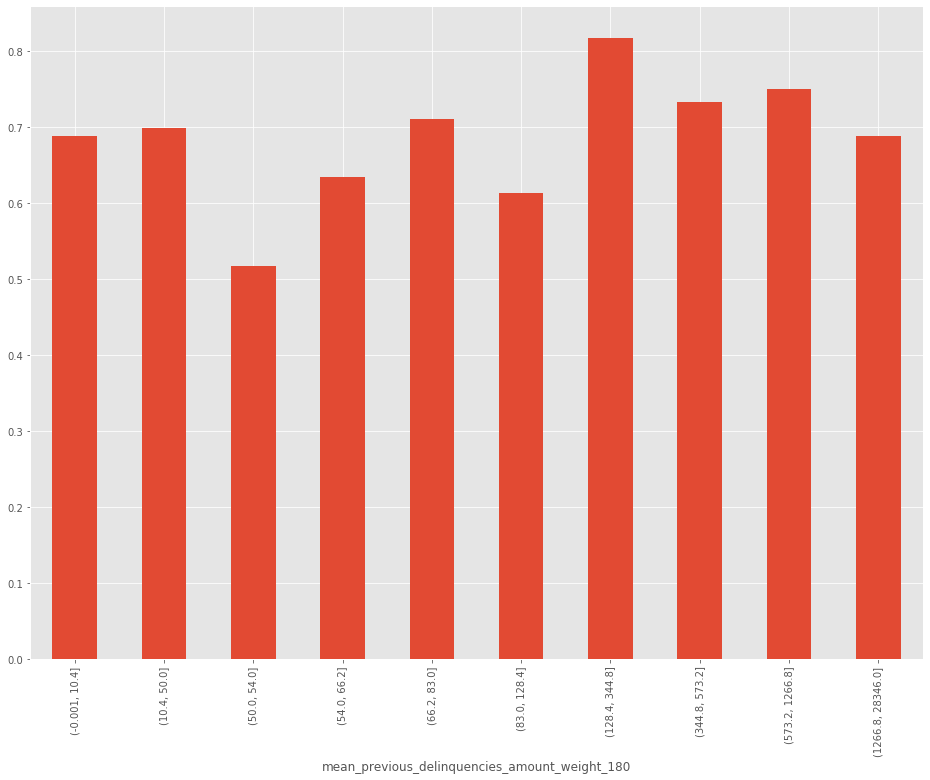

logistic_target                           0   1
mean_previous_delinquencies_duration_90        
(-0.001, 1.0]                            50  86
(1.0, 2.6]                               12  30
(2.6, 4.0]                               16  40
(4.0, 6.0]                                9  26
(6.0, 10.0]                              14  34
(10.0, 17.2]                              9  30
(17.2, 29.6]                             17  27
(29.6, 185.0]                            10  35


KeyboardInterrupt: 

In [1027]:
for i in base_discreta.columns:
    x=base_discreta.groupby( [ i,'logistic_target'])['logistic_target'].count().unstack()
    x.div(x.sum(axis=1),axis='index' )[1].plot(kind='bar')
    plt.show()
    

In [432]:
dic_pvalues={}
for i in  logistic_reference.columns:
    a=0
    a='logistic_target~'+i
    try:
        dic_pvalues[i]=logit(a      ,data=logistic_reference.fillna(0)).fit().pvalues[i]
    except:
        continue
    

         Current function value: 0.000000
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.616796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617266
         Iterations 5


C:\Users\Rafael\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.615794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617301
         Iterations 5
Optimization terminat

In [433]:
series_pvalues=pd.Series(dic_pvalues).sort_values()

In [441]:
series_pvalues=series_pvalues [series_pvalues.index!='collection_time']

In [442]:
basic_model= 'logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+'+'+'.join(series_pvalues[series_pvalues<0.25].index)

In [443]:
logit(basic_model
      ,data=logistic_reference.fillna(0)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.594040
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      431
Method:                           MLE   Df Model:                           13
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.03781
Time:                        22:43:31   Log-Likelihood:                -264.35
converged:                       True   LL-Null:                       -274.73
Covariance Type:            nonrobust   LLR p-value:                   0.07751
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.2822      0.557      2.302      0.021       0.190       2.374
age                                        -0.0107      0.012     -0.900      0.368      -0.034       0.013
bureau_1                                   -0.3294      0.292     -1.127      0.260      -0.902       0.244
bureau_2                                   -0.3112      0.294     -1.059      0.289      -0.887       0.265
bureau_1:bureau_2                           0.2577      0.425      0.607      0.544      -0.574       1.090
avg_call_duration_30                        0.0617      0.048      1.272      0.203      -0.033       0.157
downpayment_mean                            0.0015      0.002      1.020      0.308      -0.001       0.004
max_installments_balance_90                 0.0243      0.027      0.890      0.373      -0.029       0.078
income_score_1                             -0.0001   7.46e-05     -1.531      0.126      -0.000    3.19e-05
std_installments_balance_0_90              -0.0383      0.054     -0.707      0.480      -0.145       0.068
agreement_amount_mean                    2.381e-06      0.000      0.009      0.993      -0.001       0.001
mean_previous_delinquencies_duration_90     0.0065      0.006      1.055      0.291      -0.006       0.019
ongoing_agreement_downpayment              -0.0021      0.002     -1.268      0.205      -0.005       0.001
email_event_30                              0.2958      0.214      1.380      0.167      -0.124       0.716
===========================================================================================================
"""

In [937]:
basic_model

'logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+avg_call_duration_30+downpayment_mean+age+max_installments_balance_90+income_score_1+std_installments_balance_0_90+agreement_amount_mean+mean_previous_delinquencies_duration_90+ongoing_agreement_downpayment+email_event_30'

In [453]:
cut_logit=logit('''logistic_target~age+bureau_1+bureau_2+avg_call_duration_30
            +age+max_installments_balance_90+income_score_1+mean_previous_delinquencies_duration_90+
            agreement_amount_mean+ongoing_agreement_downpayment+email_event_30'''
      ,data=logistic_reference.fillna(0)).fit()

Optimization terminated successfully.
         Current function value: 0.596482
         Iterations 6


In [455]:
cut_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.03385
Time:                        22:58:42   Log-Likelihood:                -265.43
converged:                       True   LL-Null:                       -274.73
Covariance Type:            nonrobust   LLR p-value:                   0.04564
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.2658      0.551      2.296      0.022       0.185       2.346
age                                        -0.0117      0.012     -0.989      0.323      -0.035       0.011
bureau_1                                   -0.2118      0.212     -1.000      0.317      -0.627       0.203
bureau_2                                   -0.1884      0.217     -0.869      0.385      -0.613       0.236
avg_call_duration_30                        0.0636      0.048      1.313      0.189      -0.031       0.158
max_installments_balance_90                 0.0061      0.004      1.370      0.171      -0.003       0.015
income_score_1                             -0.0001   7.44e-05     -1.562      0.118      -0.000    2.96e-05
mean_previous_delinquencies_duration_90     0.0064      0.006      1.044      0.296      -0.006       0.018
agreement_amount_mean                       0.0002      0.000      1.396      0.163   -9.34e-05       0.001
ongoing_agreement_downpayment              -0.0021      0.002     -1.259      0.208      -0.005       0.001
email_event_30                              0.2617      0.212      1.232      0.218      -0.155       0.678
===========================================================================================================
"""

In [454]:
cut_logit.wald_test('bureau_2=0,bureau_1=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[1.697379]], p-value=0.4279754269849897, df_denom=2>

In [456]:
cut_logit.wald_test('bureau_2=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.7557431]], p-value=0.3846640020701, df_denom=1>

In [457]:
cut_logit.wald_test('bureau_1=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.99946908]], p-value=0.3174390079701613, df_denom=1>

In [464]:
base.groupby(['asset_late_balance'])['id' ].count()

asset_late_balance
-74.0        4
-71.0       16
-64.0       14
-63.0       16
-56.0        8
            ..
 54140.0     1
 56430.0     7
 56547.0    16
 66185.0    16
 66316.0    16
Name: id, Length: 944, dtype: int64

In [463]:
base [base['id']=='7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c']

id       date collections_start  \
39447  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-15        2017-05-15   
39894  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-16        2017-05-15   
40333  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-17        2017-05-15   
40776  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-18        2017-05-15   
41222  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-19        2017-05-15   
41666  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-20        2017-05-15   
42115  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-21        2017-05-15   
42563  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-22        2017-05-15   
43012  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-23        2017-05-15   
43455  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-24        2017-05-15   
43903  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-25        2017-05-15   
44351  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-26        2017-05-15   
44798  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-27        2017-05-15   
45245  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-28        2017-05-15   
45697  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-29        2017-05-15   
46151  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-30        2017-05-15   
46610  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-05-31        2017-05-15   
47074  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-01        2017-05-15   
47542  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-02        2017-05-15   
48006  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-03        2017-05-15   
48474  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-04        2017-05-15   
48939  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-05        2017-05-15   
49397  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-06        2017-05-15   
49859  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-07        2017-05-15   
50320  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-08        2017-05-15   
50783  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-09        2017-05-15   
51243  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-10        2017-05-15   
51704  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-11        2017-05-15   
52170  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-12        2017-05-15   
52635  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-13        2017-05-15   
53094  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-14        2017-05-15   
53544  7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c 2017-06-15        2017-05-15   

       days_late  bureau_1  bureau_2  late_payments collection__end  \
39447          0         0         0              0             NaT   
39894          1         0         0              0             NaT   
40333          2         0         0             10             NaT   
40776          3         0         0              0             NaT   
41222          4         0         0             10             NaT   
41666          5         0         0             10             NaT   
42115          6         0         0             10             NaT   
42563          7         0         0              0             NaT   
43012          8         0         0              0             NaT   
43455          9         0         0              0             NaT   
43903         10         0         0              0             NaT   
44351         11         0         0              0             NaT   
44798         12         0         0             20             NaT   
45245         13         0         0             30             NaT   
45697         14         0         0              0             NaT   
46151         15         1         0              0             NaT   
46610         16         0         0              0             NaT   
47074         17         0         1              0             NaT   
47542         18         0         0              0             NaT   
48006         19         0         0              0             NaT   
48474         20         0         0     

In [751]:
import statsmodels.api as sm

In [809]:
from math import floor

In [948]:
abs(base.corr().replace(1,0)).style.background_gradient(cmap='coolwarm')

In [873]:
base['days_late_1']=base['days_late']+1
base['days_late_range']=np.ceil(base['days_late_1']/15)
base['bureau_1_time']=0
base['bureau_2_time']=0
base.loc[(base['id'].isin(bureau_1)) & (base['days_late']>=15),'bureau_1_time']=1
base.loc[(base['id'].isin(bureau_2)) & (base['days_late']>=17),'bureau_2_time']=1

In [874]:
base_reg1=base.groupby(['id','days_late_range']).max()
base_reg1['late_payments']=base.groupby(['id','days_late_range'])['late_payments'].sum()

In [875]:
filtro1=((base_reg1['days_late']/15)% 1)>0.5

In [876]:
base_reg1=base_reg1[filtro1]

In [857]:
from statsmodels.tsa.stattools import acf, pacf

In [946]:
abs(base_reg1.corr().replace(1,0)).style.background_gradient(cmap='coolwarm')

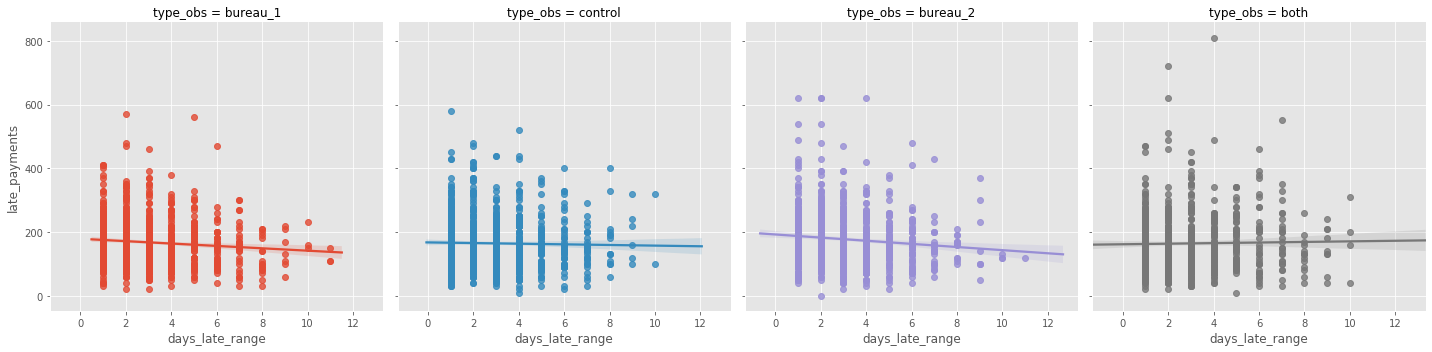

In [878]:
sns.FacetGrid(base_reg1.reset_index(), col="type_obs",hue="type_obs", size=5).map(sns.regplot, "days_late_range", "late_payments")

In [1028]:
diff=base_reg1.groupby(['type_obs','days_late_range'])['late_payments'].mean().unstack().T

In [1029]:
diff

type_obs               both    bureau_1    bureau_2     control
days_late_range                                                
1.0              165.162791  169.151786  182.333333  161.875000
2.0              154.897959  183.316583  196.149733  176.755556
3.0              171.095890  159.615385  170.516129  161.977401
4.0              162.323232  161.111111  167.387387  161.587302
5.0              170.303030  172.676056  166.533333  154.583333
6.0              176.578947  153.695652  166.363636  161.111111
7.0              185.769231  157.333333  154.814815  144.000000
8.0              129.285714  121.764706  156.923077  175.714286
9.0              148.888889  142.857143  173.750000  193.333333
10.0             177.500000  180.000000  123.333333  210.000000
11.0                    NaN  123.333333  120.000000         NaN

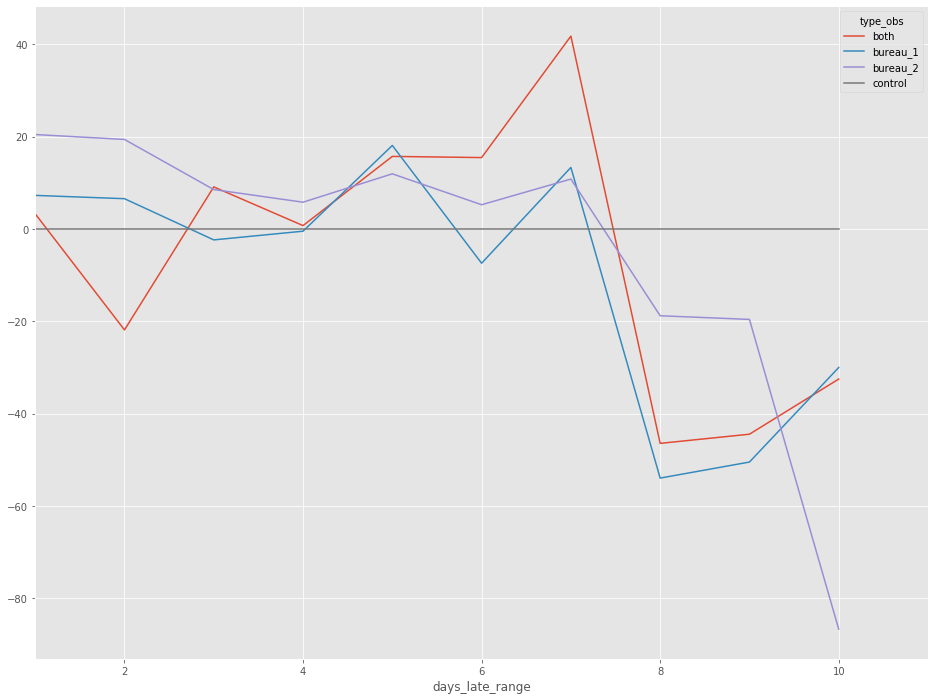

In [928]:
diff.sub(diff['control'],axis=0).plot()

In [949]:
diff=base_reg1.groupby(['type_obs','days_late_range'])['std_revolving_balance_30'].mean().unstack().T

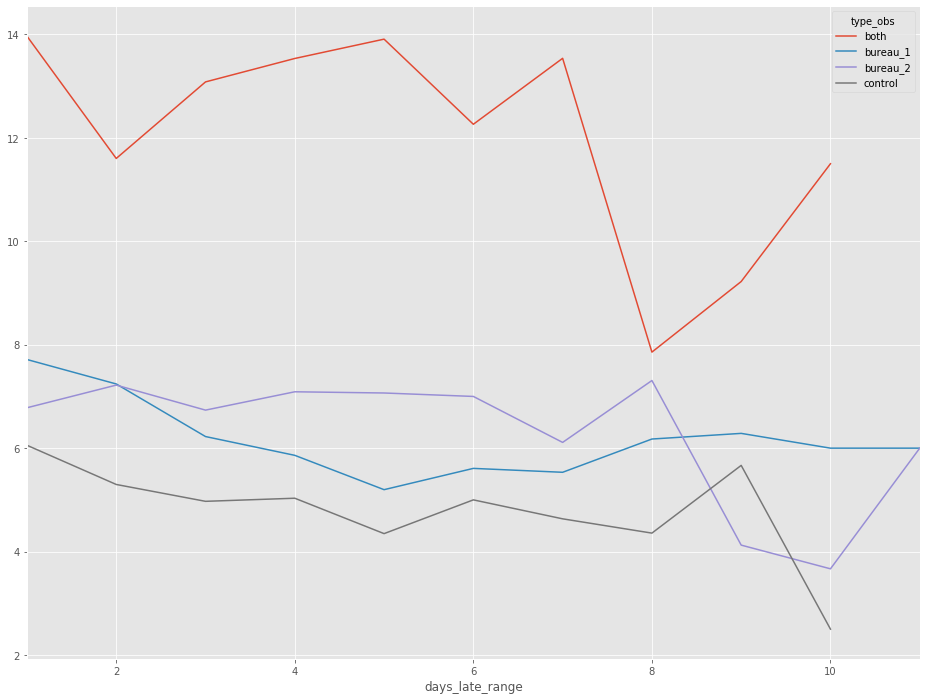

In [951]:
diff.plot()

In [957]:
diff=base_reg1.groupby(['type_obs','days_late_range'])['agreement_amount_mean'].median().unstack().T

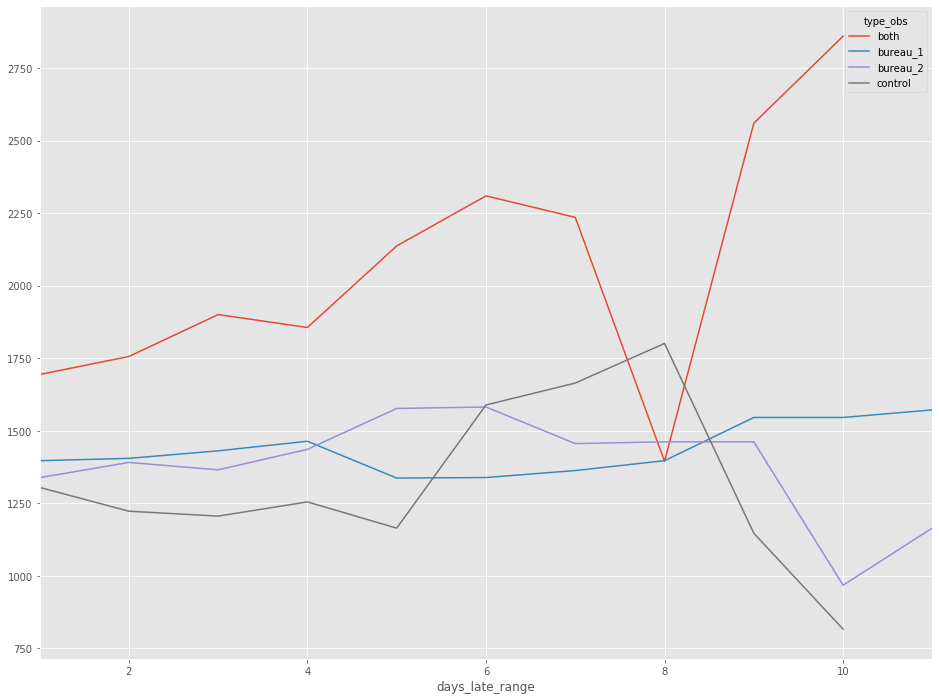

In [958]:
diff.plot()

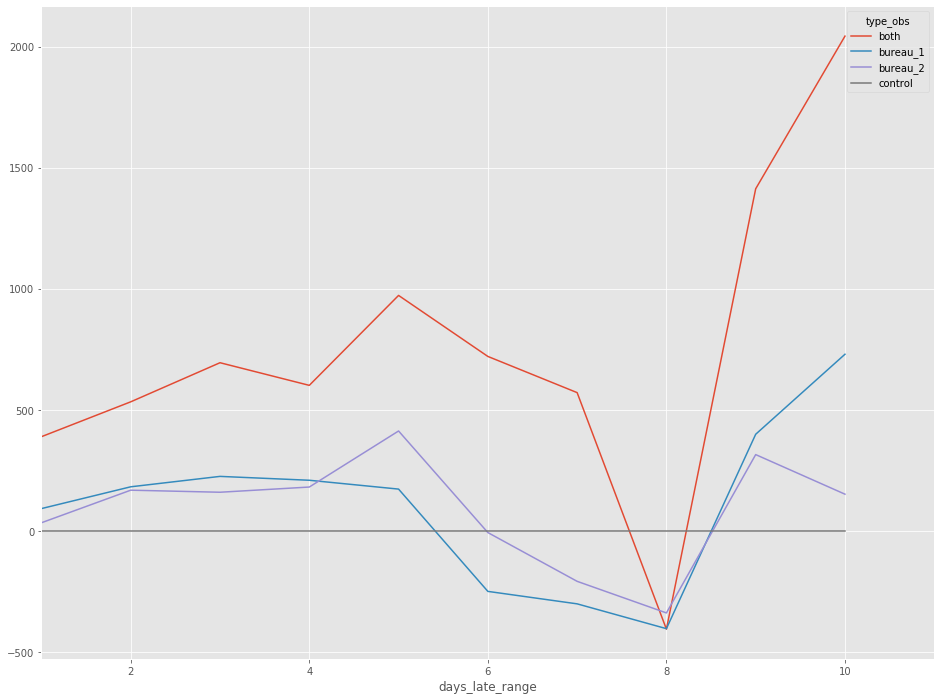

In [959]:
diff.sub(diff['control'],axis=0).plot()

In [931]:

        mod = smf.glm(formula='''late_payments ~ bureau_1_time + bureau_2_time +
                                + bureau_1_time*bureau_2_time+sum_spends_360+age+days_late_range+agreement_amount_mean ''',
                      data=base_reg1.reset_index().fillna(0), family=sm.families.Gamma())
        res = mod.fit()
        print(res.summary())
  

                 Generalized Linear Model Regression Results                  
Dep. Variable:          late_payments   No. Observations:                 3523
Model:                            GLM   Df Residuals:                     3515
Model Family:                   Gamma   Df Model:                            7
Link Function:          inverse_power   Scale:                         0.23913
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Tue, 10 Mar 2020   Deviance:                       896.49
Time:                        00:20:39   Pearson chi2:                     841.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

C:\Users\Rafael\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
C:\Users\Rafael\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


In [932]:
nobs = res.nobs
y = base_reg1['late_payments']
yhat = res.mu


In [905]:
from statsmodels.graphics.api import abline_plot

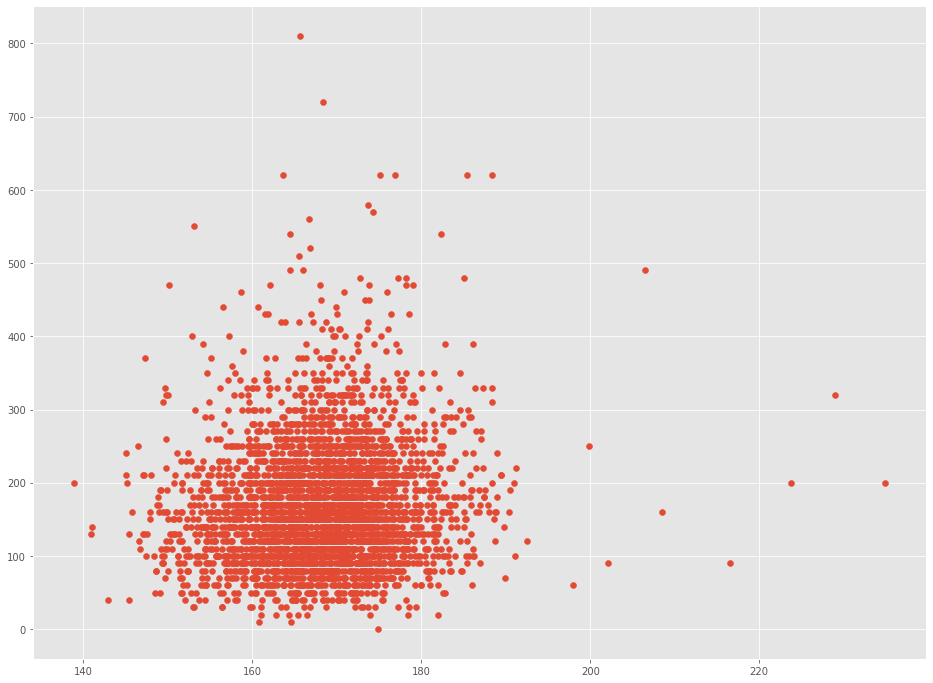

In [933]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)


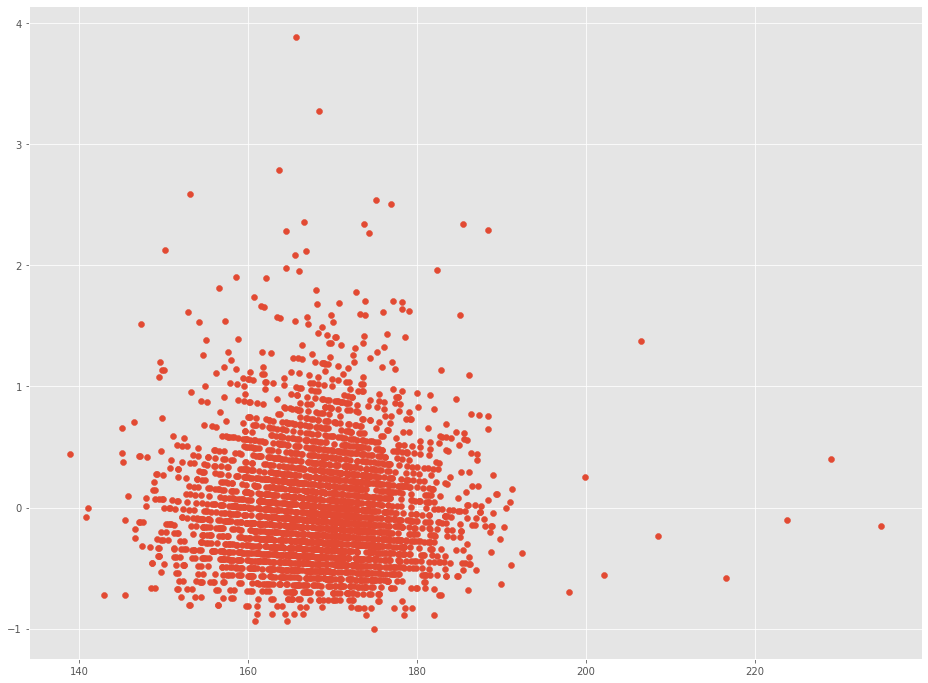

In [934]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)

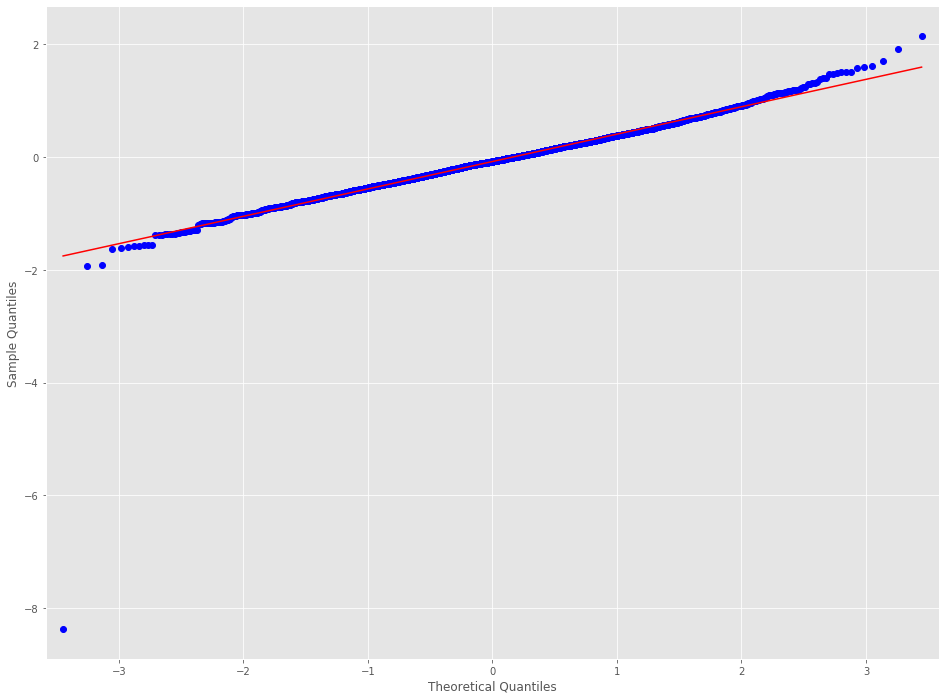

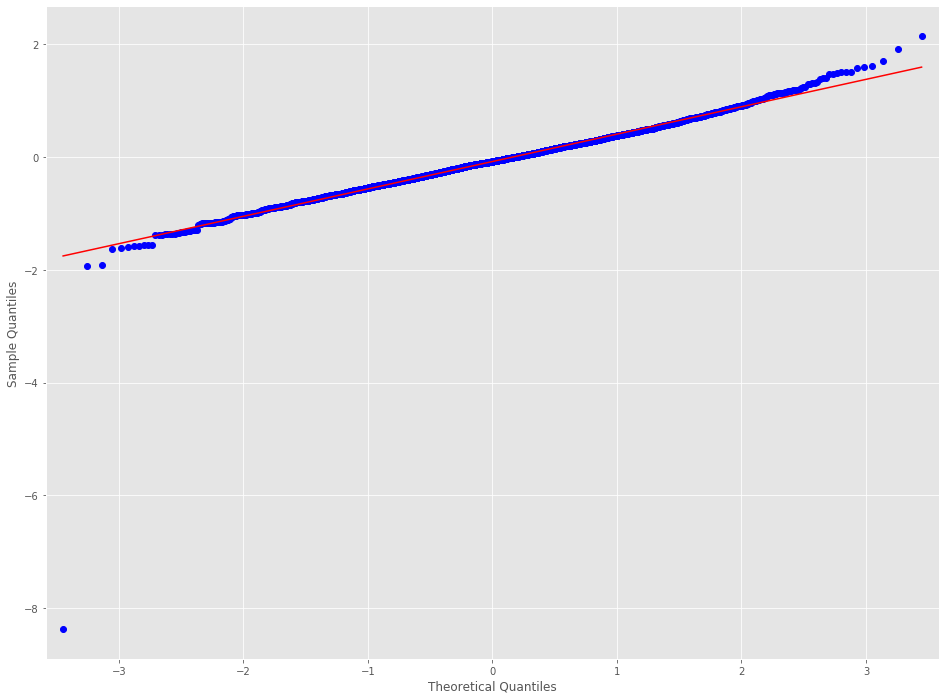

In [935]:

from statsmodels import graphics
resid = res.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')

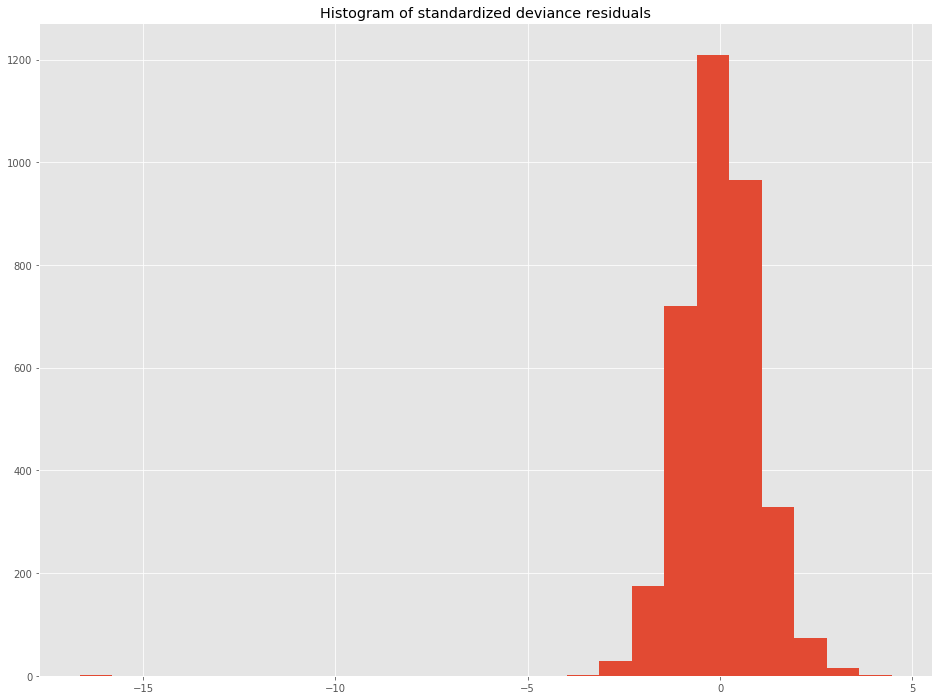

In [936]:
from scipy import stats

fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

In [594]:
#base_reg1['late_payments']=(base_reg1['late_payments'].unstack()/base_reg1['late_payments'].unstack().shift(1)).stack()

In [552]:
import statsmodels.formula.api as smf

In [964]:
mod = smf.ols(formula='''agreement_amount_mean ~ bureau_1_time + bureau_2_time +
                        + bureau_1_time*bureau_2_time+sum_spends_360+age+days_late_range ''',
              data=base_reg1.reset_index().fillna(0))
res = mod.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     agreement_amount_mean   R-squared:                       0.026
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     15.85
Date:                   Tue, 10 Mar 2020   Prob (F-statistic):           4.65e-18
Time:                           00:34:41   Log-Likelihood:                -30418.
No. Observations:                   3523   AIC:                         6.085e+04
Df Residuals:                       3516   BIC:                         6.089e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [967]:
base.groupby(  ['bureau_1_time','bureau_2_time','type_obs'])['late_payments'].sum()

bureau_1_time  bureau_2_time  type_obs
0              0              both         35510
                              bureau_1     37890
                              bureau_2     43260
                              control     173690
               1              bureau_2    113260
1              0              both          7160
                              bureau_1    113940
               1              both         96090
Name: late_payments, dtype: int64

In [1016]:
base[base['id'].isin(min_date_obs['id'])]   .query('days_late<15').groupby('type_obs')['late_payments'].mean()

type_obs
both        11.010853
bureau_1    11.276786
bureau_2    12.155556
control     11.333333
Name: late_payments, dtype: float64

In [998]:
pars=base[base['id'].isin(min_date_obs['id'])][['id','type_obs']].drop_duplicates().groupby(['type_obs']).count()

In [999]:
vol=base.query('days_late>=15').groupby('type_obs')['late_payments'].sum()

In [1007]:
pars

id
type_obs     
both      215
bureau_1  224
bureau_2  210
control   253

In [1009]:
vol=pd.DataFrame(vol)

In [1015]:
vol/pars.values

late_payments
type_obs               
both         480.232558
bureau_1     508.660714
bureau_2     563.000000
control      483.596838

In [554]:
base_reg1=base_reg1.query('days_late_range!=0').reset_index()

In [562]:
base_reg1['late_payments']=base_reg1['late_payments'].fillna(0)

In [576]:
base_reg1['late_payments']=base_reg1['late_payments'].fillna(0)

In [586]:
base_reg1['late_payments'].min()

0.0

In [577]:
base_reg1.corr()['late_payments'].sort_values()

days_late_range                                 -0.107899
days_late_1                                     -0.102430
days_late                                       -0.102430
count_inbound_call_inbound_30                   -0.026849
ongoing_agreement_amount                        -0.023601
income_score_2                                  -0.016025
age                                             -0.013184
sum_spends_360                                  -0.012975
avg_spends                                      -0.012799
month                                           -0.012505
last_email_engagement                           -0.010439
last_chat_engagement                            -0.010158
collection_time                                 -0.009713
log_max_payment_90                              -0.004301
count_previous_delinquencies                    -0.003837
income_score_1                                  -0.001241
recovery_balance                                -0.000318
oustanting_bal

In [581]:
regression= smf.mixedlm("late_payments ~ count_inbound_call_inbound_30", base_reg1, groups=base_reg1['type_obs' ])

In [654]:
bureau_1

array(['ee254bce-3eec-46cd-a440-826631a44783',
       'e4552188-6002-44f4-b539-1043cf1dd057',
       'f84bc28e-7298-4d59-a315-5a3c1125f820',
       '40249e57-7de1-42fb-9201-afab1a3965a4',
       'abd31cd5-ccc6-415c-9c76-124a01f6c898',
       'd504d6a1-1f80-4836-9c04-75f4acfbeea4',
       '44d71bfe-bb73-4e92-bd58-d13cc6ae65e8',
       '06af9fe4-25c4-4beb-ab53-201d237f0914',
       '4229213e-7fc6-4047-a62f-1cc7b148dd5d',
       '366d690e-dd8b-4d1a-a918-acd33c274e00',
       '397b98d1-a587-409c-9933-ab732a0a58ee',
       'bbb45e47-dc7b-47c0-9594-bec62cd9bc77',
       'd349451a-3c1a-4112-9944-83630b854205',
       'b6c6f0b2-c7d1-48d6-ae9a-57539148e726',
       'f01b45f4-8fe9-44fe-8e03-1357ffc326c7',
       '724292c7-0292-4222-a2bc-0937699661fb',
       '97020231-66f1-4287-89f2-55cac1f29d1e',
       '6b88af44-06dd-4c22-9c30-5c9b258248f3',
       'e0df4d5b-3332-4c24-9659-265c951e0ec3',
       '050112c6-43e5-43e3-9352-6ded88551735',
       '1d15dfa1-2860-4aa5-89d7-31273530b302',
       '5150b

In [522]:
weeklypayments=base.groupby(['days_late_range','type_obs'])['late_payments'].sum().unstack()

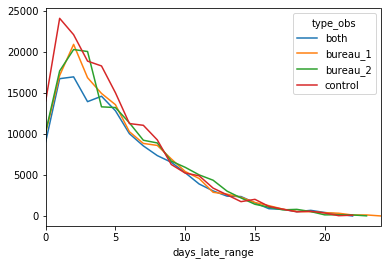

In [523]:
weeklypayments.plot()

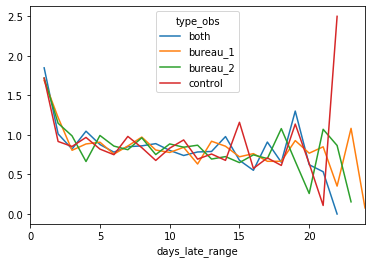

In [526]:
(weeklypayments/weeklypayments.shift(1)).plot()

In [511]:
base.groupby(['days_late_range','type_obs'])['late_payments'].sum().unstack()/base.groupby(['days_late_range','type_obs'])['late_payments'].sum().unstack().shift(-1)

type_obs             both   bureau_1  bureau_2   control
days_late_range                                         
0.0              0.540944   0.592290  0.581777  0.581811
1.0              0.987021   0.818747  0.871302  1.090086
2.0              1.216798   1.240950  1.011976  1.170641
3.0              0.954764   1.128600  1.506767  1.032276
4.0              1.138066   1.101032  1.006813  1.217855
5.0              1.278166   1.320351  1.163877  1.333037
6.0              1.174473   1.161765  1.229686  1.019005
7.0              1.160326   1.027907  1.037079  1.192017
8.0              1.123664   1.235632  1.330344  1.476115
9.0              1.242884   1.284133  1.128162  1.200765
10.0             1.351282   1.185996  1.183633  1.067347
11.0             1.274510   1.581315  1.149083  1.441176
12.0             1.264463   1.086466  1.438944  1.317829
13.0             1.021097   1.166667  1.377273  1.474286
14.0             1.472050   1.381818  1.538462  0.862069
15.0             1.808989   1.309524  1.336449  1.735043
16.0             1.098765   1.500000  1.426667  1.409639
17.0             1.528302   1.500000  0.925926  1.627451
18.0             0.768116   1.076923  1.500000  0.879310
19.0             1.604651   1.300000  3.857143  1.567568
20.0             1.869565   1.176471  0.933333  9.250000
21.0                  inf   2.833333  1.153846  0.400000
22.0                  NaN   0.923077  6.500000       NaN
23.0                  NaN  13.000000       NaN       NaN
24.0                  NaN        NaN       NaN       NaN

In [496]:
base.pivot(index='days_late',columns='id',values='late_payments').shift(1)

id         001a43ae-9992-4eb8-9bfc-c2f9ef7c6711  \
days_late                                         
0                                           NaN   
1                                          10.0   
2                                          40.0   
3                                           0.0   
4                                           0.0   
5                                           0.0   
6                                          20.0   
7                                           0.0   
8                                           0.0   
9                                           0.0   
10                                          0.0   
11                                          0.0   
12                                          0.0   
13                                          0.0   
14                                          0.0   
15                                         20.0   
16                                          0.0   
17                                         20.0   
18                                          0.0   
19                                         20.0   
20                                         10.0   
21                                         10.0   
22                                         20.0   
23                                          0.0   
24                                          0.0   
25                                          0.0   
26                                          0.0   
27                                         10.0   
28                                         10.0   
29                                          0.0   
30                                          0.0   
31                                          0.0   
32                                          0.0   
33                                          0.0   
34                                         10.0   
35                                         10.0   
36                                         10.0   
37                                          0.0   
38                                          0.0   
39                                          0.0   
40                                          0.0   
41                                         10.0   
42                                          0.0   
43                                          0.0   
44                                         10.0   
45                                          0.0   
46                                          0.0   
47                                         50.0   
48                                          0.0   
49                                          0.0   
50                                         10.0   
51                                         10.0   
52                                          0.0   
53                                          0.0   
54                                         20.0   
55                                          0.0   
56                                          0.0   
57                                          0.0   
58                                         10.0   
59                                         20.0   
60                                         10.0   
61                                          0.0   
62                                         10.0   
63                                          0.0   
64                                          0.0   
65                                         70.0   
66                                         50.0   
67                                          0.0   
68                                         10.0   
69                                         10.0   
70                                          0.0   
71                                          0.0   
72                                         10.0   
73                                         10.0   
74                                          0.0   
75                                          0.0   
76                    

In [495]:
base.pivot(index='days_late',columns='id',values='late_payments')

id         001a43ae-9992-4eb8-9bfc-c2f9ef7c6711  \
days_late                                         
0                                          10.0   
1                                          40.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
5                                          20.0   
6                                           0.0   
7                                           0.0   
8                                           0.0   
9                                           0.0   
10                                          0.0   
11                                          0.0   
12                                          0.0   
13                                          0.0   
14                                         20.0   
15                                          0.0   
16                                         20.0   
17                                          0.0   
18                                         20.0   
19                                         10.0   
20                                         10.0   
21                                         20.0   
22                                          0.0   
23                                          0.0   
24                                          0.0   
25                                          0.0   
26                                         10.0   
27                                         10.0   
28                                          0.0   
29                                          0.0   
30                                          0.0   
31                                          0.0   
32                                          0.0   
33                                         10.0   
34                                         10.0   
35                                         10.0   
36                                          0.0   
37                                          0.0   
38                                          0.0   
39                                          0.0   
40                                         10.0   
41                                          0.0   
42                                          0.0   
43                                         10.0   
44                                          0.0   
45                                          0.0   
46                                         50.0   
47                                          0.0   
48                                          0.0   
49                                         10.0   
50                                         10.0   
51                                          0.0   
52                                          0.0   
53                                         20.0   
54                                          0.0   
55                                          0.0   
56                                          0.0   
57                                         10.0   
58                                         20.0   
59                                         10.0   
60                                          0.0   
61                                         10.0   
62                                          0.0   
63                                          0.0   
64                                         70.0   
65                                         50.0   
66                                          0.0   
67                                         10.0   
68                                         10.0   
69                                          0.0   
70                                          0.0   
71                                         10.0   
72                                         10.0   
73                                          0.0   
74                                          0.0   
75                                          0.0   
76                    

In [481]:
 sm.datasets.get_rdataset("dietox", "geepack").data

C:\Users\Rafael\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


Weight        Feed  Time   Pig  Evit  Cu  Litter
0     26.50000         NaN     1  4601     1   1       1
1     27.59999    5.200005     2  4601     1   1       1
2     36.50000   17.600000     3  4601     1   1       1
3     40.29999   28.500000     4  4601     1   1       1
4     49.09998   45.200001     5  4601     1   1       1
..         ...         ...   ...   ...   ...  ..     ...
856   73.19995   83.800003     8  8442     1   3      24
857   81.69995   99.800003     9  8442     1   3      24
858   90.29999  115.200001    10  8442     1   3      24
859   96.00000  133.200001    11  8442     1   3      24
860  103.50000  151.400002    12  8442     1   3      24

[861 rows x 7 columns]

In [287]:
logit('logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+asset_late_balance+late_payments+max_payment_90+month_1'
      ,data=logistic_reference).fit().summary()

Optimization terminated successfully.
         Current function value: 0.677114
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                            8
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                0.009665
Time:                        18:59:31   Log-Likelihood:                -301.32
converged:                       True   LL-Null:                       -304.26
Covariance Type:            nonrobust   LLR p-value:                    0.6605
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4244      0.484      0.877      0.380      -0.524       1.373
age                   -0.0122      0.011     -1.093      0.275      -0.034       0.010
bureau_1              -0.4589      0.267     -1.720      0.085      -0.982       0.064
bureau_2              -0.2807      0.268     -1.046      0.296      -0.807       0.245
bureau_1:bureau_2      0.6508      0.405      1.607      0.108      -0.143       1.445
asset_late_balance -2.192e-05   2.32e-05     -0.946      0.344   -6.73e-05    2.35e-05
late_payments       5.593e-05      0.004      0.015      0.988      -0.007       0.007
max_payment_90     -4.061e-06    1.1e-05     -0.368      0.713   -2.57e-05    1.76e-05
month_1                0.0979      0.198      0.495      0.621      -0.290       0.485
======================================================================================
"""

In [302]:
logit('logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+max_payment_90'
      ,data=logistic_reference).fit().summary()

Optimization terminated successfully.
         Current function value: 0.678513
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      439
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                0.007618
Time:                        19:03:07   Log-Likelihood:                -301.94
converged:                       True   LL-Null:                       -304.26
Covariance Type:            nonrobust   LLR p-value:                    0.4619
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3772      0.471      0.802      0.423      -0.545       1.300
age                  -0.0105      0.011     -0.951      0.342      -0.032       0.011
bureau_1             -0.4587      0.266     -1.725      0.085      -0.980       0.063
bureau_2             -0.2855      0.263     -1.087      0.277      -0.800       0.229
bureau_1:bureau_2     0.6299      0.388      1.622      0.105      -0.131       1.391
max_payment_90    -3.895e-06    1.1e-05     -0.353      0.724   -2.55e-05    1.77e-05
=====================================================================================
"""

In [296]:
log_model=logit('logistic_target~age+bureau_2+bureau_1*bureau_2+income_score_1'
      ,data=logistic_reference).fit()

Optimization terminated successfully.
         Current function value: 0.675521
         Iterations 5


In [297]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  439
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.01252
Time:                        19:01:37   Log-Likelihood:                -296.55
converged:                       True   LL-Null:                       -300.31
Covariance Type:            nonrobust   LLR p-value:                    0.1846
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6591      0.497      1.327      0.184      -0.314       1.632
age                  -0.0111      0.011     -1.000      0.317      -0.033       0.011
bureau_2             -0.3122      0.265     -1.177      0.239      -0.832       0.207
bureau_1             -0.5033      0.268     -1.876      0.061      -1.029       0.023
bureau_1:bureau_2     0.6370      0.392      1.624      0.104      -0.132       1.406
income_score_1       -0.0001   7.65e-05     -1.583      0.113      -0.000    2.88e-05
=====================================================================================
"""

In [303]:
log_model=logit('logistic_target~age+bureau_1+bureau_1*bureau_2+income_score_1'
      ,data=logistic_reference).fit()

Optimization terminated successfully.
         Current function value: 0.675521
         Iterations 5


In [245]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
clf = RandomForestClassifier(max_depth=5, random_state=0,n_estimators=100)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [247]:
pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

score_1                                          0.064180
avg_late_balance_0_180                           0.062109
score_max_credit_limit                           0.057140
avg_spends                                       0.053419
income_score_2                                   0.049263
age                                              0.048241
income_score_1                                   0.046052
asset_late_balance                               0.042088
score_3                                          0.040093
score_2                                          0.039188
mean_previous_delinquencies_amount_weight_180    0.032258
loss_balance                                     0.032252
max_payment_90                                   0.032062
std_revolving_balance_30                         0.030814
last_email_engagement                            0.030440
oustanting_balance_weight_30                     0.029966
ongoing_agreement_downpayment                    0.028684
count_previous

In [300]:
log_model.pred_table()

array([[237.,  12.],
       [175.,  15.]])

In [304]:
margeff = log_model.get_margeff()
margeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:        logistic_target
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0027      0.003     -1.005      0.315      -0.008       0.003
bureau_1             -0.1215      0.064     -1.906      0.057      -0.246       0.003
bureau_2             -0.0753      0.064     -1.185      0.236      -0.200       0.049
bureau_1:bureau_2     0.1537      0.094      1.644      0.100      -0.030       0.337
income_score_1    -2.925e-05   1.83e-05     -1.601      0.109   -6.51e-05    6.57e-06
=====================================================================================
"""